In [134]:
import os
os.chdir('C:/Users/yoons/Desktop/데캡/프젝')
os.getcwd()
%config InlineBackend.figure_format = "retina"

In [135]:
import warnings
warnings.filterwarnings(action='ignore') #경고 메시지 무시
from IPython.display import display #print가 아닌 display()로 연속 출력
from IPython.display import HTML #출력 결과를 HTML로 생성

In [136]:
# !pip install folium

In [238]:
import pandas as pd
from collections import OrderedDict
import geopandas
import libpysal
from libpysal import cg, examples
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
import matplotlib_scalebar
from matplotlib_scalebar.scalebar import ScaleBar
import numpy
import ortools
from ortools.linear_solver import pywraplp
import seaborn
import shapely
from shapely.geometry import Point
import spaghetti
import sys

%matplotlib inline

# 한글폰트
import os
from matplotlib import font_manager, rc
path = 'C:/Windows/Fonts/malgun.ttf'
font_name = font_manager.FontProperties(fname=path, size=50).get_name()
plt.rc('font', family=font_name)
matplotlib.rcParams['axes.unicode_minus'] = False 

import numpy as np
import folium

In [138]:
try:
    from IPython.display import Markdown as md
except ImportError:
    pass

# Define a Class and function

In [139]:
class FacilityLocationModel:
    """Solve a facility location optimization model

    Parameters
    ----------
    name : str
        Problem model name; must also be defined as a class method.
    cij : numpy.ndarray
        cost matrix from origins (index of i) to destination (index of j).
        Default is None.
    ai : numpy.ndarray
        Client weight vector. Default is None.
    s : float
        service radius. Default is None.
    p : int
        Density of facilities to site. Default is None.
    write_lp : str
        file name (and path) of the LP file to write out.
    print_sol : bool
        print select results. Default is True.

    Methods
    -------
    build_lscp : build location set covering problem
    build_pmp : build p-median problem
    build_pcp : build p-center problem
    build_mclp : build maximal covering location problem
    add_vars : add variables to a model
    add_constrs : add contraints to a model
    add_obj : add an objective function to a model
    optimize : solve a model
    record_decisions : record optimal decision variables
    non_obj_vals : record non-objective values stats (eg. percent covered)
    print_results : print selected results

    Attributes
    ----------
    model : ortools.linear_solver.pywraplp.Solver
        proxy of <Swig Object of type 'operations_research::MPSolver *'
    n_cli : int
        total client sites
    r_cli : range
        iterable of client sites
    n_fac : int
        total candidate facility sites
    r_fac : range
        iterable of candidate facility sites
    aij : numpy.ndarray
        binary coverage matrix from cij (within s service radius)
    sij : numpy.ndarray
        demand weighted cost matrix as (ai * cij).
    fac_vars : dict
        facility decision variables
    cli_vars : dict
        client decision variables
    W : ortools.linear_solver.pywraplp.Variable
        minimized maximum variable in the p-center problem formulation
    lp_formulation : str
        linear programming formulation of the model
    solve_minutes : float
        solve time in minutes
    obj_val : int or float
        model objective value
    fac2cli : dict
        facility to client relationship lookup
    cli2fac : dict
        client to facility relationship lookup
    fac2iloc : dict
        facility to dataframe index location lookup
    n_cli_uncov : int
        count of client location outside the service radius
    cli2ncov : dict
        client to covered by count lookup
    ncov2ncli : dict
        covered by count to client count lookup
    mean_dist :
        mean distance per person to the assigned facility
    perc_served :
        percentage of weighted clients covered in `s`
    """

    def __init__(
        self, name, ai=None, cij=None, s=None, p=None, write_lp=None, print_sol=True
    ):
        # Set model information
        self.name = name
        # create a solver instance
        solver_instance = pywraplp.Solver.CBC_MIXED_INTEGER_PROGRAMMING
        # instantiate a model
        self.model = pywraplp.Solver(self.name, solver_instance)

        # Set parameters and indices
        # facility parameter
        if p:
            self.p = p
        # client count and range
        self.cij = cij
        self.n_cli = cij.shape[0]
        self.r_cli = range(self.n_cli)
        # facility count and range
        self.n_fac = self.cij.shape[1]
        self.r_fac = range(self.n_fac)
        # demand parameter
        if ai is not None:
            self.ai = ai
            self.ai_sum = ai.sum()
            # weighted demand
            try:
                self.sij = self.ai * self.cij
            except ValueError:
                self.ai = self.ai.values.reshape(self.n_cli, 1)
                self.sij = self.ai * self.cij
        # if the model has a service radius parameter
        if s:
            self.s = s
            # binary coverage matrix from cij
            self.aij = numpy.zeros(self.cij.shape)
            self.aij[self.cij <= self.s] = 1.0

        # Set decision variables, constraints, and objective function
        try:
            getattr(self, "build_" + self.name)()
        except:
            raise AttributeError(self.name, "not a defined location model.")

        # solve
        self.optimize(write_lp=write_lp)
        # records seleted decision variables
        self.record_decisions()
        # record non-objective values stats (eg. percent covered)
        self.non_obj_vals()
        # print results
        if print_sol:
            self.print_results()

    def build_lscp(self):
        """ Integer programming formulation of the Location Set Covering Problem.
        Originally Published:
            Toregas, C. and ReVelle, Charles. 1972.
            Optimal Location Under Time or Distance Constraints.
            Papers of the Regional Science Association. 28(1):133 - 144.
        """
        # Decision Variables
        self.add_vars()
        # Constraints
        self.add_constrs(constr=1)  # set coverage constraints
        # Objective Function
        self.add_obj()

    def build_pmp(self):
        """Integer programming formulation of the p-median Problem.
        Originally Published:
            S. L. Hakimi. 1964. Optimum Locations of Switching Centers and
            the Absolute Centers and Medians of a Graph. Operations Research.
            12 (3):450-459.
        Adapted from:
                -1-
            ReVelle, C.S. and Swain, R.W. 1970. Central facilities location.
            Geographical Analysis. 2(1), 30-42.
                -2-
            Toregas, C., Swain, R., ReVelle, C., Bergman, L. 1971. The Location
            of Emergency Service Facilities. Operations Research. 19 (6),
            1363-1373.
                - 3 -
            Daskin, M. (1995). Network and discrete location: Models, algorithms,
            and applications. New York: John Wiley and Sons, Inc.
        """
        # Decision Variables
        self.add_vars()
        # Constraints
        self.add_constrs(constr=2)  # assignment constraints
        self.add_constrs(constr=3)  # facility constraint
        self.add_constrs(constr=4)  # opening constraints
        # Objective Function
        self.add_obj()

    def build_pcp(self):
        """Integer programming formulation of the p-center Problem.
        Originally Published:
            S. L. Hakimi. 1964. Optimum Locations of Switching Centers and
            the Absolute Centers and Medians of a Graph. Operations Research.
            12 (3):450-459.
        Adapted from:
            Daskin, M. (1995). Network and discrete location: Models, algorithms,
            and applications. New York: John Wiley and Sons, Inc.
        """
        # Decision Variables
        self.add_vars()
        # Constraints
        self.add_constrs(constr=2)  # assignment constraints
        self.add_constrs(constr=3)  # facility constraint
        self.add_constrs(constr=4)  # opening constraints
        self.add_constrs(constr=5)  # minimized maximum constraints
        # Objective Function
        self.add_obj()

    def build_mclp(self):
        """Integer programming formulation of the Maximal Covering Location Problem.
        Originally Published:
            Church, R. L and C. ReVelle. 1974. The Maximal Covering Location
            Problem. Papers of the Regional Science Association. 32:101-18.
        """
        # Decision Variables
        self.add_vars()
        # Constraints
        self.add_constrs(constr=3)  # facility constraint
        self.add_constrs(constr=6)  # maximal coverage constraints
        # Objective Function
        self.add_obj()

    def add_vars(self):
        """Add variables to a model."""
        # facility decision variables
        self.fac_vars = {j: self.model.IntVar(0, 1, "y[%i]" % (j)) for j in self.r_fac}
        # client decision variables
        if self.name == "mclp":
            self.cli_vars = {
                (i): self.model.IntVar(0, 1, "x[%i]" % (i)) for i in self.r_cli
            }
        if self.name == "pmp" or self.name == "pcp":
            self.cli_vars = {
                (i, j): self.model.IntVar(0, 1, "x[%i,%i]" % (i, j))
                for i in self.r_cli
                for j in self.r_fac
            }
        # minimized maximum variable
        if self.name == "pcp":
            self.W = self.model.NumVar(0, self.model.infinity(), "W")

    def add_constrs(self, constr=None):
        """ Add constraints to a model.
        (1) set coverage constraints
                y1 + x2 >= 1
                x1 + x3 >= 1
                x2 >= 1
        (2) assignment constraints
                x1_1 + x1_2 + x1_3 = 1
        (3) facility constraints
                y1 + y2 + y3 = p
        (4) opening constraints
                - x1_1 + y1 >= 0
                - x2_1 + y1 >= 0
                - x3_1 + y1 >= 0
        (5) minimax constraints
                cost1_1*x1_1 + cost1_2*x1_2 + cost1_3*x1_3 - W <= 0
        (6) maximal coverage constraints
                - x1 + y1 + y3 >= 0
                - x2 + y4 >= 0
        Parameters
        ----------
        constr : int {1, 2, 3, 4, 5, 6}
            Contraint type to add to model. See above for explanation.
            Default is None.
        """
        # 1 - set covering constraints
        if constr == 1:
            for i in self.r_cli:
                self.model.Add(
                    self.model.Sum(
                        [self.aij[i, j] * self.fac_vars[j] for j in self.r_fac]
                    )
                    >= 1
                )
        # 2 - assignment constraints
        elif constr == 2:
            for i in self.r_cli:
                self.model.Add(
                    self.model.Sum([self.cli_vars[i, j] for j in self.r_fac]) == 1
                )
        # 3 - facility constraint
        elif constr == 3:
            self.model.Add(
                self.model.Sum([self.fac_vars[j] for j in self.r_fac]) == self.p
            )
        # 4 - opening constraints
        elif constr == 4:
            for i in self.r_cli:
                for j in self.r_fac:
                    self.model.Add(self.fac_vars[j] - self.cli_vars[i, j] >= 0)
        # 5 - minimax constraints
        elif constr == 5:
            for i in self.r_cli:
                self.model.Add(
                    self.model.Sum(
                        [self.cij[i, j] * self.cli_vars[i, j] for j in self.r_fac]
                    )
                    <= self.W
                )
        # 6 - max coverage constraints
        elif constr == 6:
            for i in self.r_cli:
                self.model.Add(
                    self.model.Sum(
                        [self.aij[i, j] * self.fac_vars[j] for j in self.r_fac]
                    )
                    >= self.cli_vars[i]
                )

    def add_obj(self):
        """Add an objective function to a model."""
        if self.name == "lscp":
            self.model.Minimize(self.model.Sum([self.fac_vars[j] for j in self.r_fac]))

        elif self.name == "pmp":
            obj = [
                self.sij[i, j] * self.cli_vars[i, j]
                for i in self.r_cli
                for j in self.r_fac
            ]
            self.model.Minimize(self.model.Sum(obj))

        elif self.name == "pcp":
            self.model.Minimize(self.W)

        elif self.name == "mclp":
            obj = [self.ai.flatten()[i] * self.cli_vars[i] for i in self.r_cli]
            self.model.Maximize(self.model.Sum(obj))

    def optimize(self, write_lp=False):
        """ Solve the model.
        Parameters
        ----------
        write_lp : bool
            write out the linear programming formulation
        """

        def _redirect_to_file(self, text):
            """ Write out the model in linear programming format.
            Parameters
            ----------
            text : str
                full lp formulation in str format
            """
            original = sys.stdout
            sys.stdout = open(self.name + ".lp", "w")
            print(text)
            sys.stdout = original

        self.model.Solve()
        # linear programming formulation
        if write_lp:
            self.lp_formulation = self.model.ExportModelAsLpFormat(True)
            self._redirect_to_file(self.lp_formulation)
        # WallTime() in milliseconds
        self.solve_minutes = self.model.WallTime() * 1.66667e-5
        self.obj_val = self.model.Objective().Value()

    def record_decisions(self):
        """Record decision variable relationship folowing optimization."""
        # facility-to-dataframe index location lookup
        self.fac2iloc = {v.name(): k for k, v in self.fac_vars.items()}
        # client-to-dataframe index location lookup
        self.cli2iloc = {}
        # facility-to-client lookup
        self.fac2cli = {}

        # record client/service relationships
        for j in self.r_fac:
            if self.fac_vars[j].solution_value() > 0:
                jvar = self.fac_vars[j].name()
                self.fac2cli[jvar] = []
                for i in self.r_cli:
                    ivar = None
                    if self.name == "lscp":
                        if self.aij[i, j] > 0:
                            ivar = "x[%i]" % i
                            self.fac2cli[jvar].append(ivar)
                    elif self.name == "mclp":
                        if self.cli_vars[i].solution_value() > 0:
                            if self.aij[i, j] > 0:
                                ivar = self.cli_vars[i].name()
                                self.fac2cli[jvar].append(ivar)
                    else:
                        if self.cli_vars[i, j].solution_value() > 0:
                            ivar = self.cli_vars[i, j].name()
                            ivar = ivar.split(",")[0] + "]"
                            self.fac2cli[jvar].append(ivar)
                    if ivar:
                        self.cli2iloc[ivar] = i

        # client-to-facility lookup
        self.cli2fac = {}
        for cv in list(self.cli2iloc.keys()):
            self.cli2fac[cv] = []
            for k, v in self.fac2cli.items():
                if cv in v:
                    self.cli2fac[cv].append(k)

        # count of uncovered clients
        self.n_cli_uncov = self.n_cli - len(self.cli2iloc.keys())

        # clients of clients covered by n facilities
        if self.name == "lscp" or self.name == "mclp":
            self.cli2ncov = {}
            for c, fs in self.cli2fac.items():
                self.cli2ncov[c] = len(fs)
            most_coverage = max(self.cli2ncov.values())
            self.ncov2ncli = {}
            for cov_count in range(most_coverage + 1):
                if cov_count == 0:
                    self.ncov2ncli[cov_count] = self.n_cli_uncov
                    continue
                if not cov_count in list(self.cli2ncov.keys()):
                    self.ncov2ncli[cov_count] = 0
                for c, ncov in self.cli2ncov.items():
                    if ncov >= cov_count:
                        self.ncov2ncli[cov_count] += 1

    def non_obj_vals(self):
        """Record non-objective values."""
        if self.name == "pmp":
            self.mean_dist = self.obj_val / float(self.ai_sum)

        if self.name == "mclp":
            self.perc_served = (self.obj_val / float(self.ai_sum)) * 100.0

    def print_results(self):
        """Print select results."""
        print("Solve Time:", self.solve_minutes, "minutes")

        # solve time and objective value
        if self.name == "lscp":
            u1 = "facilities needed for total coverage within a "
            u2 = "%f meter service radius" % self.s
        if self.name == "pmp":
            u1 = "total weighted distance with "
            u2 = "%i selected facilities" % self.p
        if self.name == "pcp":
            u1 = "worst case distance with "
            u2 = "%i selected facilities" % self.p
        if self.name == "mclp":
            u1 = "residents within %f meters of " % self.s
            u2 = "%i selected facilities" % self.p
        units = u1 + u2

        print("Obj. Value:", self.obj_val, units)

        if self.name == "pmp":
            print("Mean weighted distance per", "person: %f" % self.mean_dist)
        if self.name == "mclp":
            print(
                "Percent of %i" % self.ai_sum, "clients covered: %f" % self.perc_served
            )

        # coverage values
        if self.name == "lscp" or self.name == "mclp":
            for ncov, ncli in self.ncov2ncli.items():
                if ncov == 0:
                    print("--- %i clients are not covered" % ncli)
                else:
                    if ncov == 1:
                        sp = "y"
                    else:
                        sp = "ies"
                    print(
                        "--- %i clients are covered" % ncli,
                        "by %i" % ncov,
                        "facilit" + sp,
                    )


In [140]:
def add_results(model, cli_df, fac_df, print_solution=False):
    """Add decision variable relationships to a dataframe.
    Parameters
    ----------
    model : ortools.linear_solver.pywraplp.Solver
        proxy of <Swig Object of type 'operations_research::MPSolver *'
    cli_df : geopandas.GeoDataFrame
        GeoDataFrame of client locations
    fac_df : geopandas.GeoDataFrame
        GeoDataFrame of facility locations
    print_solution : bool
        print out solution decision variables. Default is False.
    Returns
    -------
    cli_df : geopandas.GeoDataFrame
        updated client locations
    fac_df : geopandas.GeoDataFrame
        updated facility locations
    """
    col_name = model.name + "_sol"
    fillers = [[cli_df, "cli2fac"], [fac_df, "fac2cli"]]
    for df, attr in fillers:
        df[col_name] = df["dv"].map(getattr(model, attr))
        df[col_name].fillna("closed", inplace=True)
    if print_solution:
        selected = fac_df[fac_df[col_name] != "closed"]
        for idx in selected.index:
            print("")
            print(selected.loc[idx, "dv"], "serving:", selected.loc[idx, col_name])
    return cli_df, fac_df

In [198]:
def plotter(
    fig=None,
    base=None,
    plot_aux=None,
    buffered=None,
    model=None,
    pt1_size=None,
    pt2_size=None,
    plot_res=None,
    save_fig=False,
    title=None,
    figsize=(10, 10),
):
    """ Top-level scenario plotter for location analytics.
    Parameters
    ----------
    fig : matplotlib.figure.Figure
        complete figure to plot. Default is None.
    base : matplotlib.axes._subplots.AxesSubplot
        individual axis to plot. Default is None.
    plot_aux : dict
        model data parameters dataframes to plot keyed by
        descriptive names. Default is None.
    plot_res : dict
        model data results dataframes to plot keyed by
        descriptive names. Default is None.
    buffered : see
        buffer distance from roads segments in `plot_base`.
        Default is None.
    pt1_size : float or float
        size of points to plot. `pt1_size` should always be the
        larger between `pt2_size` and `pt1_size`. Default is None.
    pt2_size : float or float
        size of points to plot. Default is None.
    model : ortools.linear_solver.pywraplp.Solver
        proxy of <Swig Object of type 'operations_research::MPSolver *'
    title : str
        plot title. Default is None.
    figsize : tuple
        Figure size for plot. Default is (12,12).
    save_fig : bool
        Default is False.
    Returns
    -------
    add_to_legend : list
        items to add to legend
    """
    for_multiplot = True
    if not fig and not base:
        for_multiplot = False
        fig, base = plt.subplots(1, 1, figsize=figsize)

    # add title
    if not for_multiplot:
        if model:
            title += " - " + model.name
        base.set_title(title, size=20)
    else:
        base.set_title(model.name, size=20)

    # plot non-results data
    if plot_aux:
        for k, df in plot_aux.items():
            if k == "streets":
                df.plot(ax=base, lw=2, edgecolor="k", zorder=1,color='lavender')
            if k == "buffer":
                df.plot(ax=base, facecolor="y", lw=0.25, alpha=0.25, zorder=1)
            if k == "cli_tru":
                if plot_res:
                    df = df[df[model.name + "_sol"] == "closed"]
                    psize = pt2_size / 6.0
                    pcolor = "k"
                else:
                    n_cli = df.shape[0]
                    psize = pt1_size
                    pcolor = "r"
                df.plot(ax=base, markersize=psize, edgecolor="k", facecolor=pcolor)
            if k == "fac_tru":
                if plot_res:
                    df = df[df[model.name + "_sol"] == "closed"]
                    psize = pt2_size
                    pcolor = "k"
                    pmarker = "*"
                else:
                    n_cli = df.shape[0]
                    psize = pt1_size
                    pcolor = "b"
                    pmarker = "o"
                df.plot(
                    ax=base,
                    markersize=psize,
                    edgecolor="k",
                    facecolor=pcolor,
                    marker=pmarker,
                )
                n_fac = df.shape[0]
            if k == "cli_snp":
                df.plot(
                    ax=base,
                    markersize=pt2_size,
                    edgecolor="k",
                    facecolor="r",
                    alpha=0.75,
                )
            if k == "fac_snp":
                df.plot(
                    ax=base,
                    markersize=pt2_size,
                    edgecolor="k",
                    facecolor="b",
                    alpha=0.75,
                )
        add_to_legend = list(plot_aux.keys())
    else:
        add_to_legend = None

    # plot results data
    if plot_res:
        dv_colors = dv_colorset(plot_res["fac_var"].dv)
        # facilities
        df = plot_res["fac_var"][plot_res["fac_var"][model.name + "_sol"] != "closed"]
        alpha = 1.0 / float(len(df.dv) - 2)
        if alpha > 0.5:
            alpha = 0.5
        # decision variable info for legend
        dvs_to_leg = {}
        # plot facilities
        for dv in df.dv:
            fac = df[df.dv == dv]
            fac.plot(
                ax=base,
                marker="*",
                markersize=pt1_size * 3.0,
                alpha=0.8,
                zorder=3,
                edgecolor="k",
                facecolor=dv_colors[dv],
            )
            # update decision variable info with set color
            dvs_to_leg[dv] = {"facecolor": dv_colors[dv]}
        # plot clients & service areas
        for f, c in model.fac2cli.items():
            fc = plot_res["cli_var"][plot_res["cli_var"].dv.isin(c)]
            fc.plot(
                ax=base,
                markersize=50,
                edgecolor="k",
                facecolor=dv_colors[f],
                alpha=alpha,
                zorder=2,
            )
            # update decision variable info with set client counts
            dvs_to_leg[f].update({"clients": fc.shape[0]})
            # create service area polygon
            service_area = concave_hull(df, fc, f)
            service_area.plot(
                ax=base, edgecolor="k", alpha=0.2, facecolor=dv_colors[f], zorder=1
            )
    else:
        dvs_to_leg = None

    if not model:

        class _ShellModel:
            """Object to mimic `model` when not present."""

            def __init__(self, plot_aux):
                try:
                    self.n_cli = plot_aux["cli_tru"].shape[0]
                    try:
                        self.n_fac = plot_aux["fac_tru"].shape[0]
                    except KeyError:
                        pass
                except KeyError:
                    pass

        try:
            model = _ShellModel(plot_aux)
        except (TypeError, KeyError):
            model = None

    if not for_multiplot:
        # create legend patches
        patches = create_patches(
            model=model,
            for_multiplot=for_multiplot,
            pt1_size=pt1_size,
            pt2_size=pt2_size,
            buffered=buffered,
            legend_aux=add_to_legend,
            dvs_to_leg=dvs_to_leg,
        )
        add_legend(patches, for_multiplot=for_multiplot)
    add_north_arrow(base)
    add_scale(base)

    if save_fig:
        plt.savefig(model.name + ".png")

    # if for a multiplot explicityly return items to add to legend
    if for_multiplot:
        return add_to_legend

In [142]:
def multi_plotter(
    models,
    plot_aux=None,
    plot_res=None,
    select=None,
    title=None,
    figsize=(14, 14),
    shape=(2, 2),
):
    """plot multiple base axes as one figure
    Parameters
    ----------
    models : list
        solved model objects
    select : dict
        facility-to-selection count lookup.
    shape : tuple
        dimension for subplot array. Default is (2,2).s
    plot_aux : see plotter()
    plot_res : see plotter()
    title : see plotter()
    figsize : see plotter()
    """
    pt1_size, pt2_size = 300, 60
    # convert list of models to array
    mdls = numpy.array(models).reshape(shape)
    fig, axarr = plt.subplots(
        mdls.shape[0], mdls.shape[1], figsize=figsize, sharex="col", sharey="row"
    )
    # add super title to subplot array
    plt.suptitle(title, fontsize=30)
    fig.subplots_adjust(hspace=0.1, wspace=0.005, top=0.925)
    # create each subplot
    for i in range(mdls.shape[0]):
        for j in range(mdls.shape[1]):
            add_to_legend = plotter(
                base=axarr[i, j],
                plot_aux=plot_aux,
                plot_res=plot_res,
                model=mdls[i, j],
                pt1_size=pt1_size,
                pt2_size=pt2_size,
            )
            axarr[i, j].set_aspect("equal")
    add_to_legend = set(add_to_legend)
    # decision variable color set
    dv_colors = dv_colorset(plot_res["fac_var"].dv)
    dvs_to_leg = {f: dv_colors[f] for m in models for f in m.fac2cli.keys()}
    # set ordered dict of {iloc:fac_var, color, x-selected}
    # *** models[0] can be any of the solved models
    dvs_to_leg = {
        models[0].fac2iloc[k]: (k, v, select[k]) for k, v in dvs_to_leg.items()
    }
    dvs_to_leg = OrderedDict(sorted(dvs_to_leg.items()))
    # create legend patches
    patches = create_patches(
        model=None,
        pt1_size=pt1_size,
        pt2_size=pt2_size,
        legend_aux=add_to_legend,
        dvs_to_leg=dvs_to_leg,
        for_multiplot=True,
    )
    add_legend(patches, for_multiplot=True)

In [143]:
def add_north_arrow(base):
    """add a north arrow to an axes
    Parameters
    ----------
    base : see plotter()
    """
    arw = "rarrow, pad=0.25"
    bbox_props = dict(boxstyle=arw, fc="w", ec="k", lw=2, alpha=0.75)
    base.text(
        221200,
        267200,
        "      z    ",
        bbox=bbox_props,
        fontsize="large",
        fontweight="heavy",
        ha="center",
        va="center",
        rotation=90,
    )

In [144]:
def add_scale(base):
    """add a scale bar to an axes
    Parameters
    ----------
    base : see plotter()
    """
    scalebar = ScaleBar(1, units="m", location="lower left")
    base.add_artist(scalebar)
    base.set(xticklabels=[], xticks=[], yticklabels=[], yticks=[]);

In [145]:
def create_patches(
    model=None,
    pt1_size=None,
    pt2_size=None,
    buffered=None,
    legend_aux=None,
    dvs_to_leg=None,
    for_multiplot=False,
):
    """create all patches to add to the legend.
    Parameters
    ----------
    for_multiplot : bool
        for a single plot (True), or multiplot (False).
        Default is False.
    model : see plotter()
    pt1_size : see plotter()
    pt2_size : see plotter()
    buffered : see plotter()
    legend_aux : see plotter()
    dvs_to_leg : see plotter()
    Returns
    -------
    patches : list
        legend handles matching plotted items
    """
    if pt1_size:
        ms1 = float(pt1_size) / 6.0
    if pt2_size:
        ms2 = float(pt2_size) / 8.0
    # streets -- always plot
    strs = mlines.Line2D([], [], color="k", linewidth=2, alpha=1, label="Streets")
    # all patches to add to legend
    patches = [strs]
    # non-results data
    if legend_aux:
        if "buffer" in legend_aux:
            label = "Street buffer (%sm)" % buffered
            strbuff = mpatches.Patch(
                edgecolor="None", facecolor="y", linewidth=2, alpha=0.5, label=label
            )
            patches.append(strbuff)
        if "cli_tru" in legend_aux:
            try:
                if dvs_to_leg:
                    pcolor = "k"
                    msize = ms2 / 3.0
                    plabel = "Uncovered Households " + "($n$=%i)" % model.n_cli_uncov
                else:
                    pcolor = "r"
                    msize = ms1
                    plabel = "Households ($n$=%i)" % model.n_cli
                cli_tru = mlines.Line2D(
                    [],
                    [],
                    color=pcolor,
                    marker="o",
                    ms=msize,
                    linewidth=0,
                    alpha=1,
                    markeredgecolor="k",
                    label=plabel,
                )
                patches.append(cli_tru)
            except AttributeError:
                pass
        if "fac_tru" in legend_aux:
            if dvs_to_leg:
                pcolor = "k"
                msize = ms2
                pmarker = "*"
                no_fac = model.n_fac - len(list(model.fac2cli.keys()))
                plabel = "Unselected Facilities ($n$=%i)" % no_fac
            else:
                pcolor = "b"
                msize = ms1
                pmarker = "o"
                plabel = "Little Free Library candidates" + "($n$=%i)" % model.n_fac
            fac_tru = mlines.Line2D(
                [],
                [],
                color=pcolor,
                marker=pmarker,
                ms=msize,
                markeredgecolor="k",
                linewidth=0,
                alpha=1,
                label=plabel,
            )
            patches.append(fac_tru)
        if "cli_snp" in legend_aux:
            label = "Households snapped to network"
            cli_snp = mlines.Line2D(
                [],
                [],
                color="r",
                marker="o",
                ms=ms2,
                linewidth=0,
                alpha=1,
                markeredgecolor="k",
                label=label,
            )
            patches.append(cli_snp)
        if "fac_snp" in legend_aux:
            label = "LFL candidates snapped to network"
            fac_snp = mlines.Line2D(
                [],
                [],
                color="b",
                marker="o",
                ms=ms2,
                markeredgecolor="k",
                linewidth=0,
                alpha=1,
                label=label,
            )
            patches.append(fac_snp)
    # results data for single plot
    if dvs_to_leg and not for_multiplot:
        # add facility, client, and service area patches to legend
        for k, v in dvs_to_leg.items():
            fdv_label = "Little Free Library %s" % k
            fdv = mlines.Line2D(
                [],
                [],
                color=v["facecolor"],
                marker="*",
                ms=ms1 / 2.0,
                markeredgecolor="k",
                linewidth=0,
                alpha=0.8,
                label=fdv_label,
            )
            cdv_label = "Households served by %s " % k + "($n$=%i)" % v["clients"]
            cdv = mlines.Line2D(
                [],
                [],
                color=v["facecolor"],
                marker="o",
                ms=ms1 / 6.0,
                markeredgecolor="k",
                linewidth=0,
                alpha=0.5,
                label=cdv_label,
            )
            serv_label = "%s service area" % k
            serv = mpatches.Patch(
                edgecolor="k",
                facecolor=v["facecolor"],
                linewidth=2,
                alpha=0.25,
                label=serv_label,
            )
            patches.extend([fdv, cdv, serv])
    # results data for multiplot
    if dvs_to_leg and for_multiplot:
        for idx, (k, v, n) in dvs_to_leg.items():
            fdv = mlines.Line2D(
                [],
                [],
                color=v,
                marker="*",
                ms=ms1 / 2,
                markeredgecolor="k",
                linewidth=0,
                alpha=0.8,
                label="%s ($n$=%i)" % (k, n),
            )
            patches.append(fdv)
    return patches

In [146]:
def dv_colorset(dvs):
    """decision variables color set
    Parameters
    ---------
    dvs : geopandas.GeoSeries
        facility decision variables
    Returns
    -------
    dv_colors : dict
        decision variable to set color lookup
    """
    dv_colors = [
        "firebrick",
        "silver",
        "mediumseagreen",
        "blueviolet",
        "rebeccapurple",
        "mintcream",
        "snow",
        "cyan",
        "lemonchiffon",
        "limegreen",
        "peachpuff",
        "lightcoral",
        "mediumvioletred",
        "salmon",
        "rebeccapurple",
        "crimson",
        "ivory",
        "lavenderblush",
        "deeppink",
        "darkmagenta",
        "olive",
        "aqua",
        "indigo",
        "cornsilk",
        "cornflowerblue",
        "red",
        "cadetblue",
        'plum',
        'springgreen',
        'dodgerblue',
        'palevioletred',
        'hotpink',
        'darkviolet',
        'mediumslateblue',
        'navy',
        'midnightblue',
        'cornflowerblue',
        'aliceblue',
        'steelblue',
        'darkcyan',
        'teal',
        'darkcyan',
        'azure',
        'aquamarine',
        'mintcream',    
    ]
    

    dv_colors = {dv: dv_colors[idx] for idx, dv in enumerate(dvs)}
    return dv_colors

In [147]:
def get_buffer(in_data, buff=50):
    """ geopandas.GeoDataFrame should be in a meters projection.
    Parameters
    ----------
    in_data : geopandas.GeoDataFrame
        GeoDataFrame of a shapefile representing a road network.
    buff : int or float
        Desired buffer distance. Default is 50 (meters).
    Returns
    -------
    out_data : geopandas.GeoDataFrame
        Single polygon of the unioned street buffers.
    """
    b1 = in_data.buffer(buff)  # Buffer
    ub = b1.unary_union  # Buffer Union
    b2 = geopandas.GeoSeries(ub)
    out_data = geopandas.GeoDataFrame(b2, crs=in_data.crs, columns=["geometry"])
    return out_data

In [148]:
def add_legend(patches, for_multiplot=False):
    """
    Add a legend to a plot
    Parameters
    ----------
   
    patches : list
        legend handles matching plotted items
       
    for_multiplot : create_patches
     """
    if for_multiplot:
        anchor = (1.1, 1.65)
    else:
        anchor = (1.005, 1.016)
    legend = plt.legend(
        handles=patches,
        loc="upper left",
        fancybox=True,
        framealpha=0.85,
        bbox_to_anchor=anchor,
        fontsize="x-large",
        labelspacing=1.5,
        borderpad=2.
    )
    legend.get_frame().set_facecolor("white")

## Utilizing libpysal.cg.alpha_shapes

In [149]:
def concave_hull(fac_df, cli_df, f, smoother=10):
    """Create `libpysal.cg.alpha_shape_auto()` object
    for service area representation.
    Parameters
    ----------
    fac_df : geopandas.GeoDataFrame
        GeoDataFrame of facility locations.
    cli_df : geopandas.GeoDataFrame
        GeoDataFrame of client locations.
    f : str
        facility decision variable name.
    smoother : float or int
        buffer (meters). Default is 10.
    Returns
    -------
    ccv :  geopandas.GeoDataFrame
        polygon representing facility service area
    """
    # client location coordinates
    c_array = numpy.array(
        cli_df.geometry.apply(lambda pt: [pt.x, pt.y]).squeeze().tolist()
    )
    # facility location coordinates
    f_array = numpy.array(
        fac_df[fac_df.dv == f].geometry.apply(lambda pt: [pt.x, pt.y]).squeeze()
    )
    # coordinates of all location in the set
    pts_array = numpy.vstack((c_array, f_array))
    # create alpha shape (concave hull)
    ccv = cg.alpha_shape_auto(pts_array, step=4)
    ccv = geopandas.GeoDataFrame([ccv.buffer(smoother)], columns=["geometry"])
    return ccv

In [150]:
def simulated_geo_points(in_data, needed=20, seed=0, to_file=None):
    """Generate synthetic spatial data points within an area.
    Parameters
    ----------
    in_data : geopandas.GeoDataFrame
        A single polygon of the unioned street buffers.
    needed : int
        Number of points in the buffer. Default is 20.
    seed : int
        Seed for pseudo-random number generation. Default is 0.
    to_file : str
        File name for write out.
    Returns
    -------
    sim_pts : geopandas.GeoDataFrame
        Points within the buffer.
    """
    geoms = in_data.geometry
    area = tuple(in_data.total_bounds)
    simulated_points_list = []
    simulated_points_all = False
    numpy.random.seed(seed)
    while simulated_points_all == False:
        x = numpy.random.uniform(area[0], area[2], 1)
        y = numpy.random.uniform(area[1], area[3], 1)
        point = Point(x, y)
        if geoms.intersects(point)[0]:
            simulated_points_list.append(point)
        if len(simulated_points_list) == needed:
            simulated_points_all = True
    sim_pts = geopandas.GeoDataFrame(
        simulated_points_list, columns=["geometry"], crs=in_data.crs
    )
    if to_file:
        sim_pts.to_file(to_file + ".shp")
    return sim_pts

In [151]:
def analytics_matrix(mdls):
    """Create stylized dataframe visualization of distance analytics.
    Parameters
    ----------
    mdls : models
        all modeling scenarios
    Returns
    -------
    df : geopandas.GeoDataFrame
        distance analytics matrix
    style : pandas.io.formats.style.Styler
        style dataframe view
    """
    model_names = [m.name for m in mdls]
    boiler = " to assigned facility"
    stats = {
        "abs_min": "Absolute min dist" + boiler,
        "abs_max": "Absolute max dist" + boiler,
        "mean_means": "Mean of mean dists per client" + boiler,
        "mean_stds": "Mean of StD dists per client" + boiler,
    }
    # instantiate dataframe
    df = geopandas.GeoDataFrame()
    df["stats"] = list(stats.keys())
    for n in model_names:
        df[n] = numpy.nan
    # calculate stat for each model
    for m in mdls:
        mins, maxs, stds, means = [], [], [], []
        for f, cs in m.fac2cli.items():
            rows = numpy.array([m.cli2iloc[c] for c in cs])
            col = numpy.array([m.fac2iloc[f]])
            dists = m.cij[rows[:, None], col]
            mins.append(dists.min()), maxs.append(dists.max()),
            stds.append(dists.std()), means.append(dists.mean())
        # fill cells
        calcs = [
            numpy.array(mins).min(),
            numpy.array(maxs).max(),
            numpy.array(means).mean(),
            numpy.array(stds).mean(),
        ]
        label_calc = {k: calcs[idx] for idx, k in enumerate(list(stats.keys()))}
        for k, v in label_calc.items():
            df.loc[(df["stats"] == k), m.name] = v
    # stylize
    cm = seaborn.light_palette("green", as_cmap=True, reverse=True)
    style = df.style.set_caption(stats).background_gradient(
        axis=1, cmap=cm, subset=model_names
    )
    return df, style

In [152]:
def selection_matrix(mdls):
    """create stylized dataframe visualization of selected decision variables.
    Parameters
    ----------
    mdls : models
        all modeling scenarios
    Returns
    -------
    df : geopandas.GeoDataFrame
        variable selection matrix
    style : pandas.io.formats.style.Styler
        style dataframe view
    """

    def _highlight_membership(s):
        """highlight set membership in pandas.DataFrame."""
        return ["background-color: limegreen" if v == "$\in$" else "" for v in s]

    # set index and coluns in empty dataframe
    var_index = [v.name() for k, v in models[0].fac_vars.items()]
    df = geopandas.GeoDataFrame(index=var_index, columns=[m.name for m in models])
    # if site was selected in a model label with
    # latex symbol for 'element of a set' ($\in$)
    for m in models:
        for f in df.index:
            if f in list(m.fac2cli.keys()):
                df.loc[f, m.name] = "$\in$"
    # label all other cells with latex ($\\notin$)
    df.fillna("$\\notin$", inplace=True)
    for idx in df.index:
        sel = df.loc[idx][df.loc[idx] == "$\in$"].shape[0]
        df.loc[idx, "$\sum$"] = sel
        df.loc[idx, "$\%$"] = (float(sel) / float(4)) * 100.0
    # stylize
    cm = seaborn.light_palette("green", as_cmap=True)
    style = df.style.apply(_highlight_membership).background_gradient(
        cmap=cm, subset=["$\sum$", "$\%$"]
    )
    return df, style


# 좌표 변환 함수 선언
```
#  Projection 정의
# UTM-K
proj_UTMK = Proj(init='epsg:5179') # UTM-K(Bassel) 도로명주소 지도 사용 중

# WGS1984
proj_WGS84 = Proj(init='epsg:4326') # Wgs84 경도/위도, GPS사용 전지구 좌표

# UTM-K -> WGS84 샘플
x1, y1 = 961114.519726,1727112.269174
x2, y2 = transform(proj_UTMK,proj_WGS84,x1,y1)
print(x2,y2)

# WGS84 -> UTM-K 샘플
x1, y1 = 127.07098392510115, 35.53895289091983
x2, y2 = transform(proj_WGS84, proj_UTMK, x1, y1)
print(x2,y2)



#함수화
df_xy = pd.DataFrame([
    ['A', 961114.519726,1727112.269174],
    ['B', 940934.895125,1685175.196487],
    ['C', 1087922.228298,1761958.688262]
], columns=['id', 'x', 'y'])

df_xy[['x_w84', 'y_w84']] = df_xy.apply(transform_utmk_to_w84, axis=1)

```


In [250]:
from pyproj import Proj, transform
import numpy as np
import pandas  as pd

#  Projection 정의
# UTM-K
proj_UTMK = Proj(init='epsg:5179') # UTM-K(Bassel) 도로명주소 지도 사용 중

# WGS1984
proj_WGS84 = Proj(init='epsg:4326') # Wgs84 경도/위도, GPS사용 전지구 좌표


# x, y 컬럼을 이용하여 UTM-K좌표를 WGS84로 변환한 Series데이터 반환
def transform_utmk_to_w84(df):
    return pd.Series(transform(proj_UTMK, proj_WGS84, df['x'], df['y']), index=['x', 'y'])

def transform_w84_to_utmk(df):
    return pd.Series(transform(proj_WGS84, proj_UTMK, df['x'], df['y']), index=['x', 'y'])


# Geopandas data
## 서울시 shp

In [251]:
emd = geopandas.read_file("emd_20230729/emd.shp",encoding = 'ANSI')
sig = geopandas.read_file('sig_20230729/sig.shp',encoding = 'ANSI')
display(emd.head())
display(sig.head())

EMD_CD       EMD_ENG_NM EMD_KOR_NM  \
0  11110101    Cheongun-dong        청운동   
1  11110102      Singyo-dong        신교동   
2  11110103   Gungjeong-dong        궁정동   
3  11110104       Hyoja-dong        효자동   
4  11110105  Changseong-dong        창성동   

                                            geometry  
0  POLYGON ((953700.022 1954605.065, 953693.871 1...  
1  POLYGON ((953233.465 1953996.984, 953235.183 1...  
2  POLYGON ((953560.228 1954257.466, 953561.190 1...  
3  POLYGON ((953519.843 1953890.785, 953518.489 1...  
4  POLYGON ((953516.123 1953734.362, 953516.526 1...

SIG_CD    SIG_ENG_NM SIG_KOR_NM  \
0  11110     Jongno-gu        종로구   
1  11140       Jung-gu         중구   
2  11170    Yongsan-gu        용산구   
3  11200  Seongdong-gu        성동구   
4  11215   Gwangjin-gu        광진구   

                                            geometry  
0  POLYGON ((956615.453 1953567.199, 956621.579 1...  
1  POLYGON ((957890.386 1952616.746, 957909.908 1...  
2  POLYGON ((953115.761 1950834.084, 953114.206 1...  
3  POLYGON ((959681.109 1952649.605, 959842.412 1...  
4  POLYGON ((964825.058 1952633.250, 964875.565 1...

## 서울시 치매노인시설
     - 치매 노인시설 데이터 중 해당 구만 추출한 데이터를 사용
- 파일 불러오기
- geodf 변환
- 좌표변환
- 변환 데이터 저장

In [252]:
df_facility = pd.read_excel("./전국 병의원 및 약국 현황 2022.12/1.병원정보서비스 2022.12.xlsx")

In [253]:
df_facility.columns

Index(['암호화요양기호', '요양기관명', '종별코드', '종별코드명', '시도코드', '시도코드명', '시군구코드', '시군구코드명',
       '읍면동', '우편번호', '주소', '전화번호', '병원홈페이지', '개설일자', '총의사수', '의과일반의 인원수',
       '의과인턴 인원수', '의과레지던트 인원수', '의과전문의 인원수', '치과일반의 인원수', '치과인턴 인원수',
       '치과레지던트 인원수', '치과전문의 인원수', '한방일반의 인원수', '한방인턴 인원수', '한방레지던트 인원수',
       '한방전문의 인원수', '조산사 인원수', '좌표(X)', '좌표(Y)'],
      dtype='object')

In [254]:
df_facility.head()

암호화요양기호         요양기관명  종별코드  \
0  JDQ4MTYyMiM1MSMkMSMkMCMkODkkMzgxMzUxIzExIyQxIy...  가톨릭대학교인천성모병원     1   
1  JDQ4MTYyMiM1MSMkMSMkNCMkODkkMzgxMzUxIzExIyQxIy...        강릉아산병원     1   
2  JDQ4MTg4MSM1MSMkMSMkMCMkODkkMzgxMzUxIzExIyQxIy...        강북삼성병원     1   
3  JDQ4MTg4MSM1MSMkMSMkMCMkODkkMzgxMzUxIzExIyQxIy...       건국대학교병원     1   
4  JDQ4MTYyMiM4MSMkMSMkMCMkODkkMzgxMzUxIzExIyQxIy...       경북대학교병원     1   

  종별코드명    시도코드 시도코드명   시군구코드 시군구코드명  읍면동   우편번호  ... 치과인턴 인원수 치과레지던트 인원수  \
0  상급종합  220000    인천  220003  인천부평구  부평동  21431  ...        0          0   
1  상급종합  320000    강원  320100    강릉시  NaN  25440  ...        0          0   
2  상급종합  110000    서울  110016    종로구  NaN   3181  ...        0          0   
3  상급종합  110000    서울  110023    광진구  NaN   5030  ...        0          0   
4  상급종합  230000    대구  230006   대구중구  NaN  41944  ...        0          0   

  치과전문의 인원수  한방일반의 인원수  한방인턴 인원수  한방레지던트 인원수  한방전문의 인원수  조산사 인원수       좌표(X)  \
0         1          0         0           0          0        0  126.724899   
1         2          0         0           0          0        0  128.857841   
2         4          0         0           0          0        0  126.967750   
3         3          0         0           0          0        0  127.071828   
4         1          0         0           0          0        0  128.604703   

       좌표(Y)  
0  37.484831  
1  37.818433  
2  37.568408  
3  37.540376  
4  35.866253  

[5 rows x 30 columns]

In [255]:
df_종로 = df_facility[(df_facility['시도코드명']=="서울")&(df_facility['시군구코드명']=="종로구")][['요양기관명','종별코드','시군구코드명','좌표(X)','좌표(Y)']]
df_중 = df_facility[(df_facility['시도코드명']=="서울")&(df_facility['시군구코드명']=="중구")][['요양기관명','종별코드','시군구코드명','좌표(X)','좌표(Y)']]
df_용산 = df_facility[(df_facility['시도코드명']=="서울")&(df_facility['시군구코드명']=="용산구")][['요양기관명','종별코드','시군구코드명','좌표(X)','좌표(Y)']]

In [256]:
df_종로.columns = ['요양기관명', '종별코드', '시군구코드명', 'x', 'y']
df_중.columns = ['요양기관명', '종별코드', '시군구코드명', 'x', 'y']
df_용산.columns = ['요양기관명', '종별코드', '시군구코드명', 'x', 'y']

In [257]:
proj_WGS84 = Proj(init='epsg:4326')
proj_UTMK = Proj(init='epsg:5179')

In [258]:
#함수 실행
df_종로[['utmk_x','utmk_y']] = df_종로.apply(transform_w84_to_utmk,axis=1)
df_종로.head()

요양기관명  종별코드 시군구코드명           x          y         utmk_x        utmk_y
2     강북삼성병원     1    종로구  126.967750  37.568408  952997.160353  1.952249e+06
16   서울대학교병원     1    종로구  126.999017  37.579715  955765.029626  1.953488e+06
163  서울적십자병원    11    종로구  126.966997  37.567180  952929.925344  1.952113e+06
174     세란병원    11    종로구  126.957461  37.575184  952092.848533  1.953006e+06
664     로이병원    21    종로구  126.969029  37.606838  953134.193160  1.956512e+06

In [259]:
df_중[['utmk_x','utmk_y']] = df_중.apply(transform_w84_to_utmk,axis=1)
df_중.head()

요양기관명  종별코드 시군구코드명           x          y         utmk_x  \
97        국립중앙의료원    11     중구  127.005671  37.567214  956345.277844   
300   인제대학교 서울백병원    11     중구  126.988672  37.564827  954842.644781   
772      반도정형외과병원    21     중구  127.010117  37.556009  956731.431536   
913        서울송도병원    21     중구  127.008246  37.551314  956563.433202   
1563        참바로병원    21     중구  127.016637  37.565747  957312.901051   

            utmk_y  
97    1.952098e+06  
300   1.951841e+06  
772   1.950853e+06  
913   1.950333e+06  
1563  1.951930e+06

In [260]:
df_종로 = geopandas.GeoDataFrame(df_종로, geometry=geopandas.points_from_xy(df_종로['utmk_x'], df_종로['utmk_y']))
df_종로.set_crs(epsg = 5179, inplace = True)
df_종로.head(2)

요양기관명  종별코드 시군구코드명           x          y         utmk_x        utmk_y  \
2    강북삼성병원     1    종로구  126.967750  37.568408  952997.160353  1.952249e+06   
16  서울대학교병원     1    종로구  126.999017  37.579715  955765.029626  1.953488e+06   

                          geometry  
2   POINT (952997.160 1952248.875)  
16  POINT (955765.030 1953488.130)

In [261]:
df_중 = geopandas.GeoDataFrame(df_중, geometry=geopandas.points_from_xy(df_중['utmk_x'], df_중['utmk_y']))
df_중.set_crs(epsg = 5179, inplace = True)
df_중.head(2)

요양기관명  종별코드 시군구코드명           x          y         utmk_x  \
97       국립중앙의료원    11     중구  127.005671  37.567214  956345.277844   
300  인제대학교 서울백병원    11     중구  126.988672  37.564827  954842.644781   

           utmk_y                        geometry  
97   1.952098e+06  POINT (956345.278 1952098.059)  
300  1.951841e+06  POINT (954842.645 1951841.308)

# 가중치 데이터

In [331]:
df_dementia = pd.read_csv("realfinal_df.csv")

In [332]:
df_dementia

행정구    치매환자수    유병률         이용률  접근가능비율     독거노인비율   수급자노인비율
0    종로구  2790.19  10.90   93.406593   44.68  37.694862  6.497363
1     중구  2277.44  10.41   97.590361   80.51  32.531883  8.556932
2    용산구  3840.21  10.92  100.000000   38.31  29.437353  6.883121
3    성동구  4187.20   9.75   92.344498   49.82  32.694323  6.067876
4    광진구  4425.98   9.33   93.445378   61.98  24.043520  5.686694
5    중랑구  5954.03   9.07   91.340550   43.75  27.341911  9.560375
6    성북구  6937.87   9.98   85.997358   44.52  24.780072  5.957288
7    강북구  5746.57   9.56   95.615276   40.08  28.433306  8.595226
8    도봉구  5802.35   9.81   92.482517   85.08  23.632030  5.571615
9    노원구  8183.80  10.03   90.084191   70.56  26.841450  9.198826
10   은평구  7736.10   9.67   92.314488   65.02  24.297161  2.147581
11  서대문구  5301.45  10.51   85.430464   71.37  24.478428  5.794028
12   마포구  5309.54  10.48   98.675497   41.68  24.767038  5.176498
13   양천구  5608.27   9.05   94.605809   63.36  22.738710  6.350000
14   강서구  7719.81   9.14   91.265597   38.85  24.743061  8.783272
15   구로구  5855.02   8.90   82.425488   54.35  22.678783  4.847582
16   금천구  3312.60   8.92   92.603129   38.61  27.527507  8.403701
17  영등포구  5464.38   9.71   92.692308   61.97  24.634077  6.137203
18   동작구  5937.57   9.65   93.675889   62.02  23.729778  5.319893
19   관악구  6689.00   8.99   92.462312   38.04  28.686988  7.520777
20   서초구  5173.73   9.21   94.864048   57.00  16.997313  3.021191
21   강남구  6331.49   9.04   78.423237   51.34  19.415063  5.705103
22   송파구  7625.30   8.68   93.409379   60.80  19.735719  3.980150
23   강동구  5612.32   8.63   78.716745   18.63  22.408649  5.668676

# 이용기관 데이터

In [263]:
df_place_중구 = pd.read_excel("주야간주소_중구.xlsx")
df_place_중구_1 = df_place_중구.drop(['Unnamed: 0','Unnamed: 1'], axis = 1).copy()
df_place_중구_2 = df_place_중구_1.drop([0,1], axis = 0)

In [264]:
df_place_중구_2.columns = df_place_중구_2.iloc[0,:]

2         장기요양기관          급여종류                 평가결과  정원  현원  잔여  대기  방문목욕차량  \
2         장기요양기관          급여종류                 평가결과  정원  현원  잔여  대기  방문목욕차량   
3       신당데이케어센터  주야간보호내치매전담1실  A (최우수)\n2019\n정기평가  16  16   0   5     NaN   
4       신당데이케어센터         주야간보호  A (최우수)\n2019\n정기평가  42  41   1   3     NaN   
5       남산실버복지센터         주야간보호  A (최우수)\n2019\n정기평가  34  34   0  20     NaN   
6    신당동성당데이케어센터         주야간보호   B (우수)\n2019\n정기평가  21  19   2   4     NaN   
7  구립중림어르신데이케어센터         주야간보호   B (우수)\n2020\n정기평가  21  21   0  10     NaN   
8      해피움데이케어센터         주야간보호                 신설기관  27  13  14   2     NaN   
9    정담재활주야간보호센터         주야간보호                 신설기관  42  42   0   3     NaN   

2                              주소          전화번호  
2                              주소          전화번호  
3        서울특별시 중구 다산로25길  6 (신당동)  02-2231-1949  
4        서울특별시 중구 다산로25길  6 (신당동)  02-2231-1949  
5       서울특별시 중구 동호로5길  189 (신당동)  02-2238-9941  
6       서울특별시 중구 동호로20다길  9 (신당동)  02-2236-1781  
7    서울특별시 중구 서소문로6길  16 4층 (중림동)   02-363-5666  
8   서울특별시 중구 충무로  56 3 4층 (을지로3가)  02-1670-4255  
9   서울특별시 중구 다산로36길  101 2층 (신당동)  02-2231-9947

In [265]:
df_place_중구_3 = df_place_중구_2.drop([2], axis =0)
df_place_중구_4 = df_place_중구_3.reset_index(drop=True)

In [335]:
df_place_중구_4 = df_place_중구_4.astype({'현원':'int','정원':'int','대기':'int'})

df_place_중구_4['weights']=(df_place_중구_4['현원']/df_place_중구_4['정원'])+(df_place_중구_4['대기']/df_place_중구_4['정원'])

In [347]:
df_place_종로 = pd.read_excel("주야간_종로구.xlsx")
df_place_종로_1 = df_place_종로.drop(['Unnamed: 0','Unnamed: 1'], axis = 1).copy()
df_place_종로_2 = df_place_종로_1.drop([0,1], axis = 0)
df_place_종로_2.columns = df_place_종로_2.iloc[0,:]
df_place_종로_2

2           장기요양기관          급여종류                 평가결과  정원  현원  잔여  대기  방문목욕차량  \
2           장기요양기관          급여종류                 평가결과  정원  현원  잔여  대기  방문목욕차량   
3         보현데이케어센터  주야간보호내치매전담1실   B (우수)\n2019\n정기평가  20  22  -2   5     NaN   
4      혜화동성당데이케어센터         주야간보호  A (최우수)\n2020\n정기평가  21  21   0   1     NaN   
5         보현데이케어센터         주야간보호   B (우수)\n2019\n정기평가   0   0   0   0     NaN   
6         종로데이케어센터         주야간보호   B (우수)\n2019\n정기평가  17  16   1   0     NaN   
..             ...           ...                  ...  ..  ..  ..  ..     ...   
64        평창동시니어센터   노인요양시설(개정법)   B (우수)\n2021\n정기평가  68  68   0   0     NaN   
65  해피움시니어스타워(종로점)   노인요양시설(개정법)   B (우수)\n2021\n정기평가  77  63  14   0     NaN   
66         청운노인요양원   노인요양시설(개정법)   B (우수)\n2021\n정기평가  45  35  10  10     NaN   
67          세검정실버홈   노인요양시설(개정법)   C (양호)\n2021\n정기평가  23  23   0   0     NaN   
68       아름다운재활요양원   노인요양시설(개정법)                 신설기관  58  55   3  17     NaN   

2                                주소          전화번호  
2                                주소          전화번호  
3       서울특별시 종로구 평창4길  21-22 (평창동)   02-394-5511  
4      서울특별시 종로구 혜화로12길  14-9 (혜화동)   02-742-0515  
5       서울특별시 종로구 평창4길  21-22 (평창동)   02-394-5511  
6    서울특별시 종로구 지봉로13길  82 (창신동, 3층)   02-741-4904  
..                              ...           ...  
64        서울특별시 종로구 평창15길  10 (평창동)   02-391-7936  
65         서울특별시 종로구 홍지문길  29 (홍지동)  02-1877-5255  
66          서울특별시 종로구 비봉길  76 (구기동)  02-3217-0057  
67          서울특별시 종로구 평창2길  5 (평창동)   02-391-7936  
68         서울특별시 종로구 평창25길  8 (평창동)  02-2135-3909  

[67 rows x 10 columns]

In [348]:
df_place_종로_3 = df_place_종로_2.drop([2], axis =0)
df_place_종로_4 = df_place_종로_3.reset_index(drop=True)
df_place_종로_4

2           장기요양기관          급여종류                 평가결과  정원  현원  잔여  대기 방문목욕차량  \
0         보현데이케어센터  주야간보호내치매전담1실   B (우수)\n2019\n정기평가  20  22  -2   5    NaN   
1      혜화동성당데이케어센터         주야간보호  A (최우수)\n2020\n정기평가  21  21   0   1    NaN   
2         보현데이케어센터         주야간보호   B (우수)\n2019\n정기평가   0   0   0   0    NaN   
3         종로데이케어센터         주야간보호   B (우수)\n2019\n정기평가  17  16   1   0    NaN   
4       청운실버데이케어센터         주야간보호   B (우수)\n2019\n정기평가  20  17   3  27    NaN   
..             ...           ...                  ...  ..  ..  ..  ..    ...   
61        평창동시니어센터   노인요양시설(개정법)   B (우수)\n2021\n정기평가  68  68   0   0    NaN   
62  해피움시니어스타워(종로점)   노인요양시설(개정법)   B (우수)\n2021\n정기평가  77  63  14   0    NaN   
63         청운노인요양원   노인요양시설(개정법)   B (우수)\n2021\n정기평가  45  35  10  10    NaN   
64          세검정실버홈   노인요양시설(개정법)   C (양호)\n2021\n정기평가  23  23   0   0    NaN   
65       아름다운재활요양원   노인요양시설(개정법)                 신설기관  58  55   3  17    NaN   

2                                주소          전화번호  
0       서울특별시 종로구 평창4길  21-22 (평창동)   02-394-5511  
1      서울특별시 종로구 혜화로12길  14-9 (혜화동)   02-742-0515  
2       서울특별시 종로구 평창4길  21-22 (평창동)   02-394-5511  
3    서울특별시 종로구 지봉로13길  82 (창신동, 3층)   02-741-4904  
4       서울특별시 종로구 자하문로28길  29 (청운동)   02-730-4966  
..                              ...           ...  
61        서울특별시 종로구 평창15길  10 (평창동)   02-391-7936  
62         서울특별시 종로구 홍지문길  29 (홍지동)  02-1877-5255  
63          서울특별시 종로구 비봉길  76 (구기동)  02-3217-0057  
64          서울특별시 종로구 평창2길  5 (평창동)   02-391-7936  
65         서울특별시 종로구 평창25길  8 (평창동)  02-2135-3909  

[66 rows x 10 columns]

In [349]:
df_place_종로_4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66 entries, 0 to 65
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   장기요양기관  66 non-null     object
 1   급여종류    66 non-null     object
 2   평가결과    66 non-null     object
 3   정원      66 non-null     object
 4   현원      66 non-null     object
 5   잔여      66 non-null     object
 6   대기      66 non-null     object
 7   방문목욕차량  15 non-null     object
 8   주소      66 non-null     object
 9   전화번호    66 non-null     object
dtypes: object(10)
memory usage: 5.3+ KB


In [357]:
df_place_종로_4['대기'].unique()

array(['5', '1', '0', '27', '-', '10', '17'], dtype=object)

In [358]:
df_place_종로_4['현원'] = df_place_종로_4['현원'].replace('-',0)
df_place_종로_4['정원'] = df_place_종로_4['정원'].replace('-',0)
df_place_종로_4['대기'] = df_place_종로_4['대기'].replace('-',0)

In [359]:
df_place_종로_4 = df_place_종로_4.astype({'현원':'int','정원':'int','대기':'int'}).copy()

In [360]:

df_place_종로_4['weights']=(df_place_종로_4['현원']/df_place_종로_4['정원'])+(df_place_종로_4['대기']/df_place_종로_4['정원'])

In [362]:
df_p_종로 = df_place_종로_4[['장기요양기관','주소','weights']].copy()
df_p_중구 = df_place_중구_4[['장기요양기관','주소','weights']].copy()

In [364]:
df_p_종로['weights'] = df_p_종로['weights'].fillna(0)
df_p_종로

2           장기요양기관                               주소   weights
0         보현데이케어센터      서울특별시 종로구 평창4길  21-22 (평창동)  1.350000
1      혜화동성당데이케어센터     서울특별시 종로구 혜화로12길  14-9 (혜화동)  1.047619
2         보현데이케어센터      서울특별시 종로구 평창4길  21-22 (평창동)  0.000000
3         종로데이케어센터   서울특별시 종로구 지봉로13길  82 (창신동, 3층)  0.941176
4       청운실버데이케어센터      서울특별시 종로구 자하문로28길  29 (청운동)  2.200000
..             ...                              ...       ...
61        평창동시니어센터        서울특별시 종로구 평창15길  10 (평창동)  1.000000
62  해피움시니어스타워(종로점)         서울특별시 종로구 홍지문길  29 (홍지동)  0.818182
63         청운노인요양원          서울특별시 종로구 비봉길  76 (구기동)  1.000000
64          세검정실버홈          서울특별시 종로구 평창2길  5 (평창동)  1.000000
65       아름다운재활요양원         서울특별시 종로구 평창25길  8 (평창동)  1.241379

[66 rows x 3 columns]

In [365]:
df_p_중구

2         장기요양기관                              주소   weights
0       신당데이케어센터        서울특별시 중구 다산로25길  6 (신당동)  1.312500
1       신당데이케어센터        서울특별시 중구 다산로25길  6 (신당동)  1.047619
2       남산실버복지센터       서울특별시 중구 동호로5길  189 (신당동)  1.588235
3    신당동성당데이케어센터       서울특별시 중구 동호로20다길  9 (신당동)  1.095238
4  구립중림어르신데이케어센터    서울특별시 중구 서소문로6길  16 4층 (중림동)  1.476190
5      해피움데이케어센터   서울특별시 중구 충무로  56 3 4층 (을지로3가)  0.555556
6    정담재활주야간보호센터   서울특별시 중구 다산로36길  101 2층 (신당동)  1.071429

In [366]:
from geopy.geocoders import Nominatim

In [367]:
df_p_종로['도로명'] = df_p_종로.주소.str.split(' ').str[3]+" "+df_p_종로.주소.str.split(' ').str[5]

In [368]:
geolocoder = Nominatim(user_agent = 'South Korea')
def geocoding(address): 
    geo = geolocoder.geocode(address)
    crd = (geo.latitude, geo.longitude)
    print(crd)
    return crd

In [369]:
list_p_종로=list(df_p_종로['도로명'])

In [370]:

j = 0
for i in list_p_종로: 
    print(i)
    crd = geocoding(i)
    df_p_종로.loc[j,'y'] = crd[0]
    df_p_종로.loc[j,'x'] = crd[1]
    j = j+1

평창4길 21-22
(37.611627, 126.9630005)
혜화로12길 14-9
(37.5900529, 127.0001254)
평창4길 21-22
(37.611627, 126.9630005)
지봉로13길 82
(37.5774224, 127.013386)
자하문로28길 29
(37.5864959, 126.97253573577196)
율곡로17길 7-38
(37.5768376, 127.0048887)
지봉로 82
(37.487254899999996, 126.80844435)
사직로 105
(37.5723579, 126.9634282)
지봉로 49
(37.48636295, 126.80495389059978)
창신6길 3
(37.5757102, 127.0116997)
지봉로 101-31
(34.9206571, 127.54314)
홍지문길 29
(37.5973689, 126.9554664)
자하문로 292
(37.5945443, 126.9636187)
창신12길 3
(37.5785962, 127.0106859)
종로65길 22
(37.5760626, 127.019901)
지봉로12나길 1
(37.5778393, 127.0168958)
평창11길 9-1
(37.6058808, 126.9667013)
지봉로 81
(37.4876337, 126.80829340445862)
옥인길 64
(37.5811813, 126.9662513)
창신8길 3
(37.5772068, 127.0103133)
종로 381-1
(37.5701496, 126.9827925)
성균관로 53
(37.5855161, 126.9974806)
지봉로 81
(37.4876337, 126.80829340445862)
성균관로16길 21
(37.5880031, 126.9983979)
사직로 105
(37.5723579, 126.9634282)
지봉로 77-3
(34.9363359, 127.5383704)
사직로8길 21-2
(37.57469235, 126.97111676291523)
사직로 66
(35.19

In [371]:
df_p_종로

2           장기요양기관                               주소   weights          도로명  \
0         보현데이케어센터      서울특별시 종로구 평창4길  21-22 (평창동)  1.350000   평창4길 21-22   
1      혜화동성당데이케어센터     서울특별시 종로구 혜화로12길  14-9 (혜화동)  1.047619  혜화로12길 14-9   
2         보현데이케어센터      서울특별시 종로구 평창4길  21-22 (평창동)  0.000000   평창4길 21-22   
3         종로데이케어센터   서울특별시 종로구 지봉로13길  82 (창신동, 3층)  0.941176    지봉로13길 82   
4       청운실버데이케어센터      서울특별시 종로구 자하문로28길  29 (청운동)  2.200000   자하문로28길 29   
..             ...                              ...       ...          ...   
61        평창동시니어센터        서울특별시 종로구 평창15길  10 (평창동)  1.000000     평창15길 10   
62  해피움시니어스타워(종로점)         서울특별시 종로구 홍지문길  29 (홍지동)  0.818182      홍지문길 29   
63         청운노인요양원          서울특별시 종로구 비봉길  76 (구기동)  1.000000       비봉길 76   
64          세검정실버홈          서울특별시 종로구 평창2길  5 (평창동)  1.000000       평창2길 5   
65       아름다운재활요양원         서울특별시 종로구 평창25길  8 (평창동)  1.241379      평창25길 8   

2           y           x  
0   37.611627  126.963001  
1   37.590053  127.000125  
2   37.611627  126.963001  
3   37.577422  127.013386  
4   37.586496  126.972536  
..        ...         ...  
61  37.610398  126.965022  
62  37.597369  126.955466  
63  36.313586  128.672361  
64  37.605933  126.963417  
65  37.611155  126.972136  

[66 rows x 6 columns]

In [372]:
df_p_중구['도로명'] = df_p_중구.주소.str.split(' ').str[3]+" "+df_p_중구.주소.str.split(' ').str[5]

In [373]:
list_p_중구=list(df_p_중구['도로명'])
j = 0
for i in list_p_중구: 
    print(i)
    crd = geocoding(i)
    df_p_중구.loc[j,'y'] = crd[0]
    df_p_중구.loc[j,'x'] = crd[1]
    j = j+1

다산로25길 6
(37.5593539, 127.0122075)
다산로25길 6
(37.5593539, 127.0122075)
동호로5길 189
(35.8679386, 128.7253804)
동호로20다길 9
(37.5589362, 127.0110251)
서소문로6길 16
(37.5602275, 126.9657864)
충무로 56
(36.786879049999996, 127.11828586306122)
다산로36길 101
(37.5624598, 127.0164076)


In [374]:
df_p_중구

2         장기요양기관                              주소   weights         도로명  \
0       신당데이케어센터        서울특별시 중구 다산로25길  6 (신당동)  1.312500    다산로25길 6   
1       신당데이케어센터        서울특별시 중구 다산로25길  6 (신당동)  1.047619    다산로25길 6   
2       남산실버복지센터       서울특별시 중구 동호로5길  189 (신당동)  1.588235   동호로5길 189   
3    신당동성당데이케어센터       서울특별시 중구 동호로20다길  9 (신당동)  1.095238   동호로20다길 9   
4  구립중림어르신데이케어센터    서울특별시 중구 서소문로6길  16 4층 (중림동)  1.476190   서소문로6길 16   
5      해피움데이케어센터   서울특별시 중구 충무로  56 3 4층 (을지로3가)  0.555556      충무로 56   
6    정담재활주야간보호센터   서울특별시 중구 다산로36길  101 2층 (신당동)  1.071429  다산로36길 101   

2          y           x  
0  37.559354  127.012208  
1  37.559354  127.012208  
2  35.867939  128.725380  
3  37.558936  127.011025  
4  37.560228  126.965786  
5  36.786879  127.118286  
6  37.562460  127.016408

In [375]:
proj_WGS84 = Proj(init='epsg:4326')
proj_UTMK = Proj(init='epsg:5179')

In [376]:
df_중

요양기관명  종별코드 시군구코드명           x          y         utmk_x  \
97         국립중앙의료원    11     중구  127.005671  37.567214  956345.277844   
300    인제대학교 서울백병원    11     중구  126.988672  37.564827  954842.644781   
772       반도정형외과병원    21     중구  127.010117  37.556009  956731.431536   
913         서울송도병원    21     중구  127.008246  37.551314  956563.433202   
1563         참바로병원    21     중구  127.016637  37.565747  957312.901051   
...            ...   ...    ...         ...        ...            ...   
75071        한맥한의원    93     중구  127.010925  37.553997  956801.654551   
75779       혜화당한의원    93     중구  126.992882  37.566093  955215.180426   
75871        홍익한의원    93     중구  127.021930  37.565880  957780.347937   
76157        효정한의원    93     중구  126.992108  37.562665  955144.814523   
76199        휴본한의원    93     중구  126.978937  37.567289  953984.434889   

             utmk_y                        geometry      dv  \
97     1.952098e+06  POINT (956345.278 1952098.059)    y[0]   
300    1.951841e+06  POINT (954842.645 1951841.308)    y[1]   
772    1.950853e+06  POINT (956731.432 1950852.844)    y[2]   
913    1.950333e+06  POINT (956563.433 1950332.833)    y[3]   
1563   1.951930e+06  POINT (957312.901 1951930.232)    y[4]   
...             ...                             ...     ...   
75071  1.950629e+06  POINT (956801.655 1950629.307)  y[576]   
75779  1.951980e+06  POINT (955215.180 1951979.774)  y[577]   
75871  1.951943e+06  POINT (957780.348 1951942.608)  y[578]   
76157  1.951600e+06  POINT (955144.815 1951599.746)  y[579]   
76199  1.952119e+06  POINT (953984.435 1952119.157)  y[580]   

                                         lscp_sol  
97                                         closed  
300                                        closed  
772                                        closed  
913                                        closed  
1563                                       closed  
...                                           ...  
75071                                      closed  
75779                                      closed  
75871                                      closed  
76157                                      closed  
76199  [x[0], x[1], x[2], x[3], x[4], x[5], x[6]]  

[581 rows x 10 columns]

In [377]:
df_p_중구

2         장기요양기관                              주소   weights         도로명  \
0       신당데이케어센터        서울특별시 중구 다산로25길  6 (신당동)  1.312500    다산로25길 6   
1       신당데이케어센터        서울특별시 중구 다산로25길  6 (신당동)  1.047619    다산로25길 6   
2       남산실버복지센터       서울특별시 중구 동호로5길  189 (신당동)  1.588235   동호로5길 189   
3    신당동성당데이케어센터       서울특별시 중구 동호로20다길  9 (신당동)  1.095238   동호로20다길 9   
4  구립중림어르신데이케어센터    서울특별시 중구 서소문로6길  16 4층 (중림동)  1.476190   서소문로6길 16   
5      해피움데이케어센터   서울특별시 중구 충무로  56 3 4층 (을지로3가)  0.555556      충무로 56   
6    정담재활주야간보호센터   서울특별시 중구 다산로36길  101 2층 (신당동)  1.071429  다산로36길 101   

2          y           x  
0  37.559354  127.012208  
1  37.559354  127.012208  
2  35.867939  128.725380  
3  37.558936  127.011025  
4  37.560228  126.965786  
5  36.786879  127.118286  
6  37.562460  127.016408

In [378]:
#함수 실행
df_p_중구[['utmk_x','utmk_y']] = df_p_중구.apply(transform_w84_to_utmk,axis=1)
df_p_중구.head()

2         장기요양기관                             주소   weights        도로명  \
0       신당데이케어센터       서울특별시 중구 다산로25길  6 (신당동)  1.312500   다산로25길 6   
1       신당데이케어센터       서울특별시 중구 다산로25길  6 (신당동)  1.047619   다산로25길 6   
2       남산실버복지센터      서울특별시 중구 동호로5길  189 (신당동)  1.588235  동호로5길 189   
3    신당동성당데이케어센터      서울특별시 중구 동호로20다길  9 (신당동)  1.095238  동호로20다길 9   
4  구립중림어르신데이케어센터   서울특별시 중구 서소문로6길  16 4층 (중림동)  1.476190  서소문로6길 16   

2          y           x        utmk_x        utmk_y  
0  37.559354  127.012208  9.569180e+05  1.951223e+06  
1  37.559354  127.012208  9.569180e+05  1.951223e+06  
2  35.867939  128.725380  1.110627e+06  1.764179e+06  
3  37.558936  127.011025  9.568133e+05  1.951177e+06  
4  37.560228  126.965786  9.528186e+05  1.951342e+06

In [379]:
df_p_종로[['utmk_x','utmk_y']] = df_p_종로.apply(transform_w84_to_utmk,axis=1)
df_p_종로.head()

2       장기요양기관                               주소   weights          도로명  \
0     보현데이케어센터      서울특별시 종로구 평창4길  21-22 (평창동)  1.350000   평창4길 21-22   
1  혜화동성당데이케어센터     서울특별시 종로구 혜화로12길  14-9 (혜화동)  1.047619  혜화로12길 14-9   
2     보현데이케어센터      서울특별시 종로구 평창4길  21-22 (평창동)  0.000000   평창4길 21-22   
3     종로데이케어센터   서울특별시 종로구 지봉로13길  82 (창신동, 3층)  0.941176    지봉로13길 82   
4   청운실버데이케어센터      서울특별시 종로구 자하문로28길  29 (청운동)  2.200000   자하문로28길 29   

2          y           x         utmk_x        utmk_y  
0  37.611627  126.963001  952605.144773  1.957046e+06  
1  37.590053  127.000125  955869.018953  1.954635e+06  
2  37.611627  126.963001  952605.144773  1.957046e+06  
3  37.577422  127.013386  957032.467546  1.953227e+06  
4  37.586496  126.972536  953431.056733  1.954253e+06

In [380]:
df_p_종로 = geopandas.GeoDataFrame(df_p_종로, geometry=geopandas.points_from_xy(df_p_종로['utmk_x'], df_p_종로['utmk_y']))
df_p_종로.set_crs(epsg = 5179, inplace = True)
df_p_종로.head(2)

2       장기요양기관                             주소   weights          도로명  \
0     보현데이케어센터    서울특별시 종로구 평창4길  21-22 (평창동)  1.350000   평창4길 21-22   
1  혜화동성당데이케어센터   서울특별시 종로구 혜화로12길  14-9 (혜화동)  1.047619  혜화로12길 14-9   

2          y           x         utmk_x        utmk_y  \
0  37.611627  126.963001  952605.144773  1.957046e+06   
1  37.590053  127.000125  955869.018953  1.954635e+06   

2                        geometry  
0  POINT (952605.145 1957046.186)  
1  POINT (955869.019 1954634.539)

In [381]:
df_p_중구 = geopandas.GeoDataFrame(df_p_중구, geometry=geopandas.points_from_xy(df_p_중구['utmk_x'], df_p_중구['utmk_y']))
df_p_중구.set_crs(epsg = 5179, inplace = True)
df_p_중구.head(2)

2    장기요양기관                         주소   weights       도로명          y  \
0  신당데이케어센터   서울특별시 중구 다산로25길  6 (신당동)  1.312500  다산로25길 6  37.559354   
1  신당데이케어센터   서울특별시 중구 다산로25길  6 (신당동)  1.047619  다산로25길 6  37.559354   

2           x         utmk_x        utmk_y                        geometry  
0  127.012208  956918.000737  1.951223e+06  POINT (956918.001 1951223.027)  
1  127.012208  956918.000737  1.951223e+06  POINT (956918.001 1951223.027)

# 입지 모델

## 중구

### 구추출

In [382]:
display(sig[sig['SIG_KOR_NM']=='중구'])
jung_streets = emd[emd['EMD_CD'].str.startswith('11140')]
jung_streets 

SIG_CD SIG_ENG_NM SIG_KOR_NM  \
1   11140    Jung-gu         중구   
25  26110    Jung-gu         중구   
41  27110    Jung-gu         중구   
50  28110    Jung-gu         중구   
66  30140    Jung-gu         중구   
70  31110    Jung-gu         중구   

                                             geometry  
1   POLYGON ((957890.386 1952616.746, 957909.908 1...  
25  POLYGON ((1139632.900 1681213.674, 1139636.835...  
41  POLYGON ((1099266.034 1764845.475, 1099328.023...  
50  MULTIPOLYGON (((912369.264 1929393.401, 912478...  
66  POLYGON ((995945.175 1811588.887, 995945.178 1...  
70  POLYGON ((1165946.465 1735060.511, 1165927.884...

EMD_CD             EMD_ENG_NM EMD_KOR_NM  \
87   11140101             Mugyo-dong        무교동   
88   11140102                Da-dong         다동   
89   11140103   Taepyeongno 1(il)-ga      태평로1가   
90   11140104       Euljiro 1(il)-ga      을지로1가   
91   11140105        Euljiro 2(i)-ga      을지로2가   
..        ...                    ...        ...   
156  11140170  Chungjeongno 1(il)-ga      충정로1가   
157  11140171           Jungnim-dong        중림동   
158  11140172         Uijuro 2(i)-ga      의주로2가   
159  11140173    Malli-dong 1(il)-ga      만리동1가   
160  11140174     Malli-dong 2(i)-ga      만리동2가   

                                              geometry  
87   POLYGON ((954067.500 1952312.646, 954067.435 1...  
88   POLYGON ((954306.958 1952309.564, 954304.771 1...  
89   POLYGON ((953742.948 1952362.913, 953744.062 1...  
90   POLYGON ((954059.158 1952076.965, 954067.013 1...  
91   POLYGON ((954932.662 1952055.900, 954933.044 1...  
..                                                 ...  
156  POLYGON ((953131.621 1952217.678, 953132.506 1...  
157  POLYGON ((953024.776 1951485.640, 953027.473 1...  
158  POLYGON ((953189.271 1951545.995, 953190.589 1...  
159  POLYGON ((953120.380 1950964.105, 953120.385 1...  
160  POLYGON ((952723.818 1950948.340, 952731.922 1...  

[74 rows x 4 columns]

<Axes: >

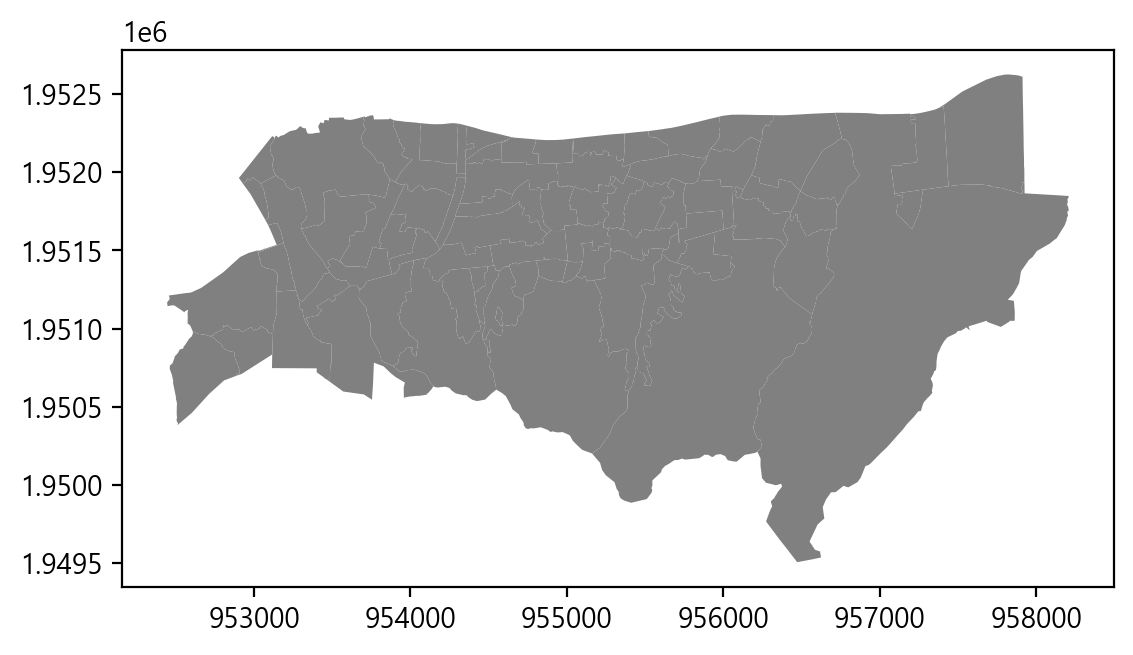

In [383]:
jung_streets.plot(color='grey')

<Axes: >

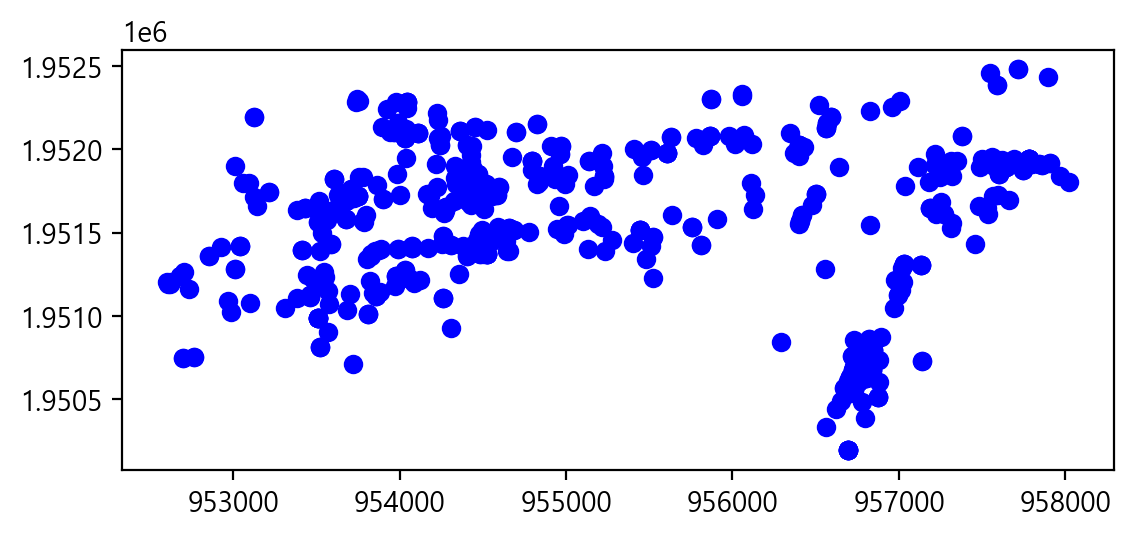

In [384]:
df_중.plot(color = 'blue')

<Axes: >

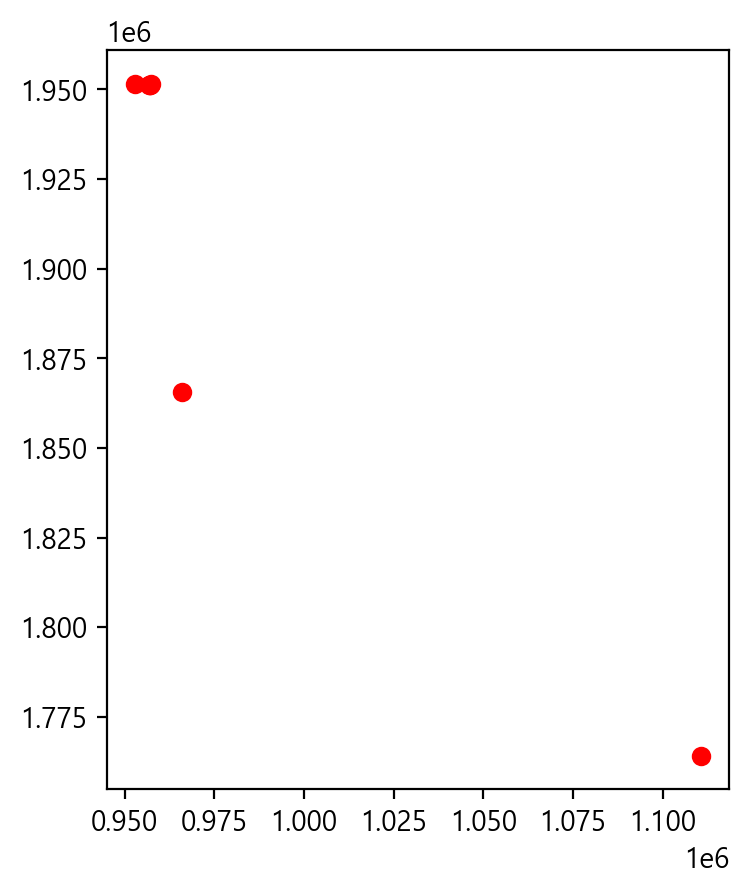

In [385]:
df_p_중구.plot(color = 'red')

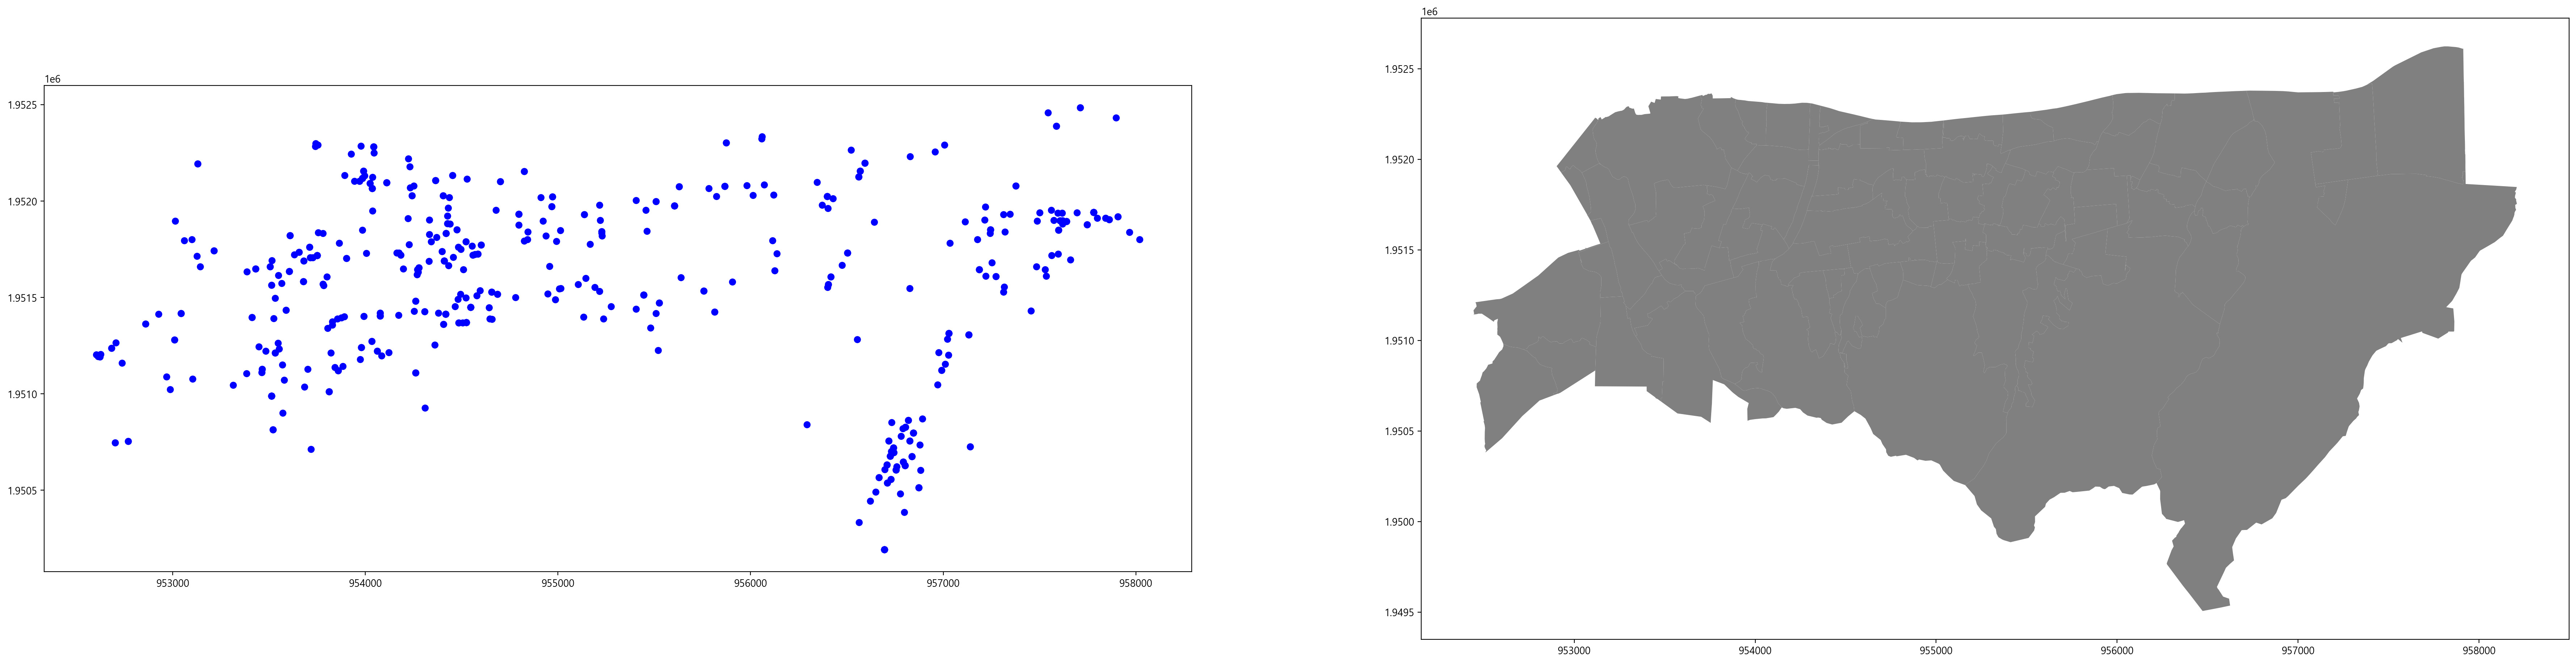

In [386]:
fig, ax =plt.subplots(1,2,figsize=(45,15))
df_중.plot(color = 'blue', ax = ax[0])
jung_streets.plot(color='grey', ax = ax[1])
plt.show()

### 세팅

In [387]:
# 고객수, 필요 설치개수 = x,y
client_count, facility_count = df_p_중구.shape[0], df_중.shape[0]

# 설치개수
p_facilities = 3

# 커버할 수 있는 최대 지역 범위
max_coverage = 6500.0

# 커버할 수 있는 최소 지역 범위
min_coverage = 2000.0

title = "Jung Neighborhood X"

In [388]:
buff = 100
streets_buffer = get_buffer(jung_streets, buff=buff)


In [389]:
streets = jung_streets

clients = df_p_중구
clients["dv"] = ["x[%s]" % c for c in range(client_count)]



facilities = df_중
facilities["dv"] = ["y[%s]" % c for c in range(facility_count)]

display(clients.head(2))
display(facilities.head(3))

2    장기요양기관                         주소   weights       도로명          y  \
0  신당데이케어센터   서울특별시 중구 다산로25길  6 (신당동)  1.312500  다산로25길 6  37.559354   
1  신당데이케어센터   서울특별시 중구 다산로25길  6 (신당동)  1.047619  다산로25길 6  37.559354   

2           x         utmk_x        utmk_y                        geometry  \
0  127.012208  956918.000737  1.951223e+06  POINT (956918.001 1951223.027)   
1  127.012208  956918.000737  1.951223e+06  POINT (956918.001 1951223.027)   

2    dv  
0  x[0]  
1  x[1]

요양기관명  종별코드 시군구코드명           x          y         utmk_x  \
97       국립중앙의료원    11     중구  127.005671  37.567214  956345.277844   
300  인제대학교 서울백병원    11     중구  126.988672  37.564827  954842.644781   
772     반도정형외과병원    21     중구  127.010117  37.556009  956731.431536   

           utmk_y                        geometry    dv lscp_sol  
97   1.952098e+06  POINT (956345.278 1952098.059)  y[0]   closed  
300  1.951841e+06  POINT (954842.645 1951841.308)  y[1]   closed  
772  1.950853e+06  POINT (956731.432 1950852.844)  y[2]   closed

In [390]:
add_to_plot = {
    "streets": streets,
    "buffer": streets_buffer,
    "cli_tru": clients,
    "fac_tru": facilities,
}

plotter(plot_aux=add_to_plot, buffered=buff, pt1_size=60,figsize=(10,10))

### 모델링

In [391]:
ntw = spaghetti.Network(in_data=streets)

In [392]:
ntw.snapobservations(clients, "clients", attribute=True)
clients_snapped = spaghetti.element_as_gdf(
    ntw, pp_name="clients", snapped=True
)
ntw.snapobservations(facilities, "facilities", attribute=True)
facilities_snapped = spaghetti.element_as_gdf(
    ntw, pp_name="facilities", snapped=True
)
cost_matrix = ntw.allneighbordistances(
    sourcepattern=ntw.pointpatterns["clients"],
    destpattern=ntw.pointpatterns["facilities"],
)
cost_matrix[:3,:3]

array([[1423.89800178, 3129.50274951,  430.43995431],
       [1423.89800178, 3129.50274951,  430.43995431],
       [3802.37815467, 4963.63251835, 2039.26866782]])

In [393]:
add_to_plot = {
    "streets": streets,
    "buffer": streets_buffer,
    "cli_tru": clients,
    "fac_tru": facilities,
    "cli_snp": clients_snapped,
    "fac_snp": facilities_snapped,
}
plotter(plot_aux=add_to_plot, buffered=buff, pt1_size=60, pt2_size=10)

#### LSCP

In [394]:
lscp = FacilityLocationModel("lscp", cij=cost_matrix, s=4900)
clients, facilities = add_results(lscp, clients, facilities)

Solve Time: 0.0039833413 minutes
Obj. Value: 1.0 facilities needed for total coverage within a 4900.000000 meter service radius
--- 0 clients are not covered
--- 7 clients are covered by 1 facility


IndexError: list index out of range

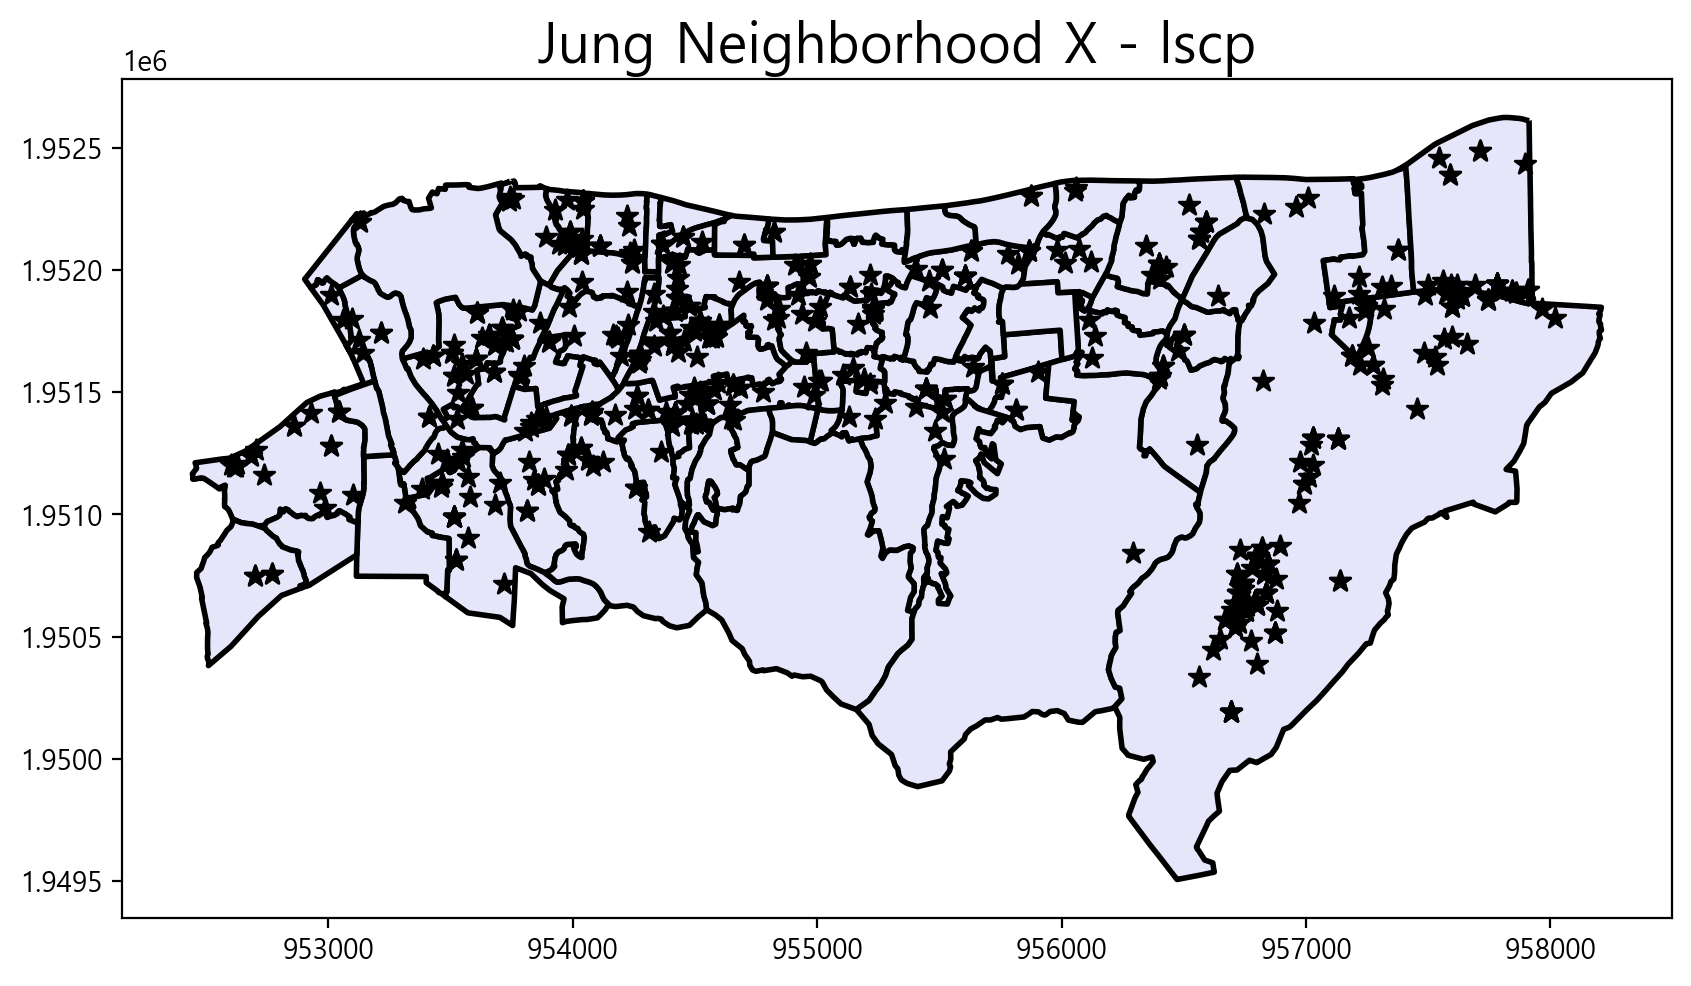

In [395]:
aux_to_plot = {"streets": streets, "fac_tru": facilities}
res_to_plot = {"cli_var": clients, "fac_var": facilities}
plotter(
    plot_aux=aux_to_plot,
    plot_res=res_to_plot,
    pt1_size=300,
    pt2_size=60,
    model=lscp,
    title=title,
)

#### MCLP

In [396]:
mclp = FacilityLocationModel(
    "mclp", ai=clients["weights"], cij=cost_matrix, p=p_facilities, s=4000
)
clients, facilities = add_results(mclp, clients, facilities)

Solve Time: 0.0021500043 minutes
Obj. Value: 8.146767040149394 residents within 4000.000000 meters of 3 selected facilities
Percent of 8 clients covered: 100.000000
--- 0 clients are not covered
--- 7 clients are covered by 1 facility
--- 4 clients are covered by 2 facilities
--- 3 clients are covered by 3 facilities


IndexError: list index out of range

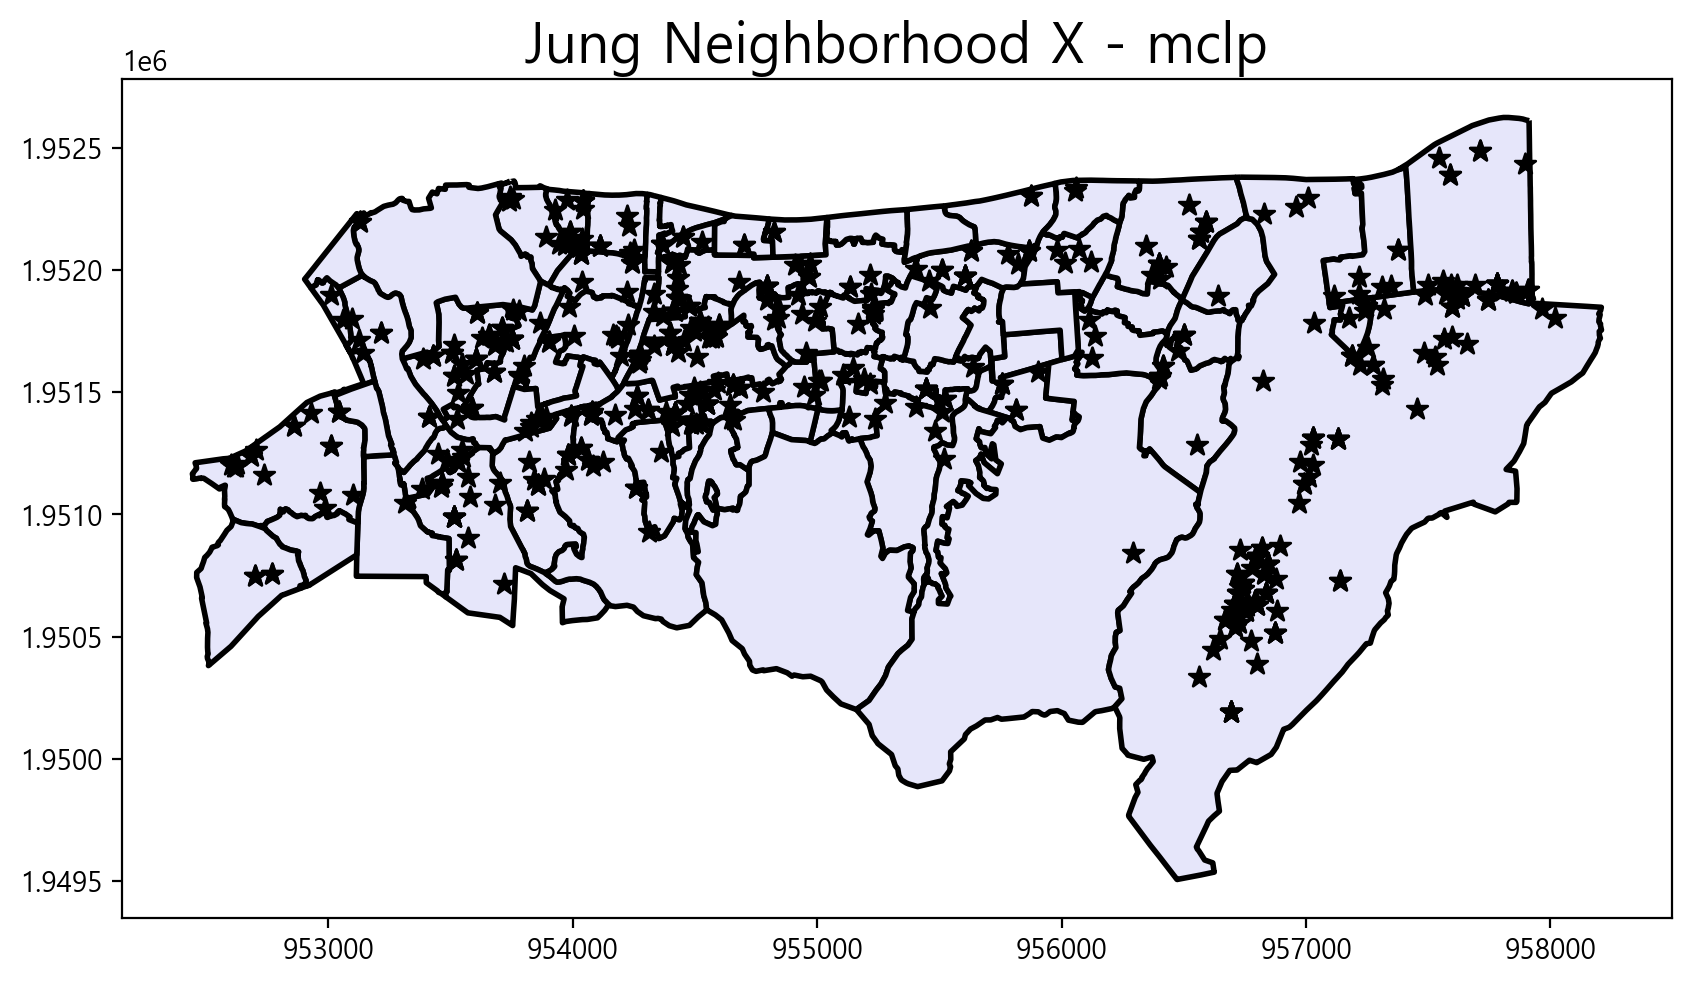

In [405]:
aux_to_plot = {"streets": streets, "cli_tru": clients, "fac_tru": facilities}
res_to_plot = {"cli_var": clients, "fac_var": facilities}
plotter(
    plot_aux=aux_to_plot,
    plot_res=res_to_plot,
    pt1_size=300,
    pt2_size=60,
    model=mclp,
    title=title,
)


In [398]:
models = [lscp, mclp]

In [399]:
analytics_df, analytics_display = analytics_matrix(models)
analytics_display

ValueError: `caption` must be either a string or 2-tuple of strings.

In [400]:
selection_df, selection_display = selection_matrix(models)
selection_display

In [401]:
facilities[facilities["mclp_sol"] != "closed"][["dv", "geometry"]]

dv                        geometry
11865   y[59]  POINT (957780.348 1951942.608)
18009  y[116]  POINT (955866.048 1952077.739)
22261  y[169]  POINT (954341.240 1951789.578)

<Axes: >

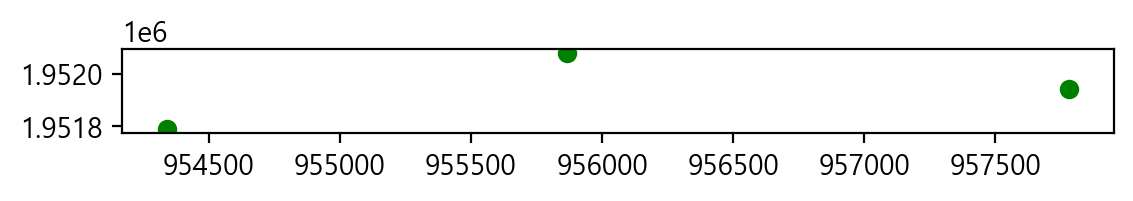

In [402]:
facilities[facilities["mclp_sol"] != "closed"][["dv", "geometry"]].plot(color='green')

## 종로구

In [407]:
display(sig[sig['SIG_KOR_NM']=='종로구'])
jongro_streets = emd[emd['EMD_CD'].str.startswith('11110')]
jongro_streets 

SIG_CD SIG_ENG_NM SIG_KOR_NM  \
0  11110  Jongno-gu        종로구   

                                            geometry  
0  POLYGON ((956615.453 1953567.199, 956621.579 1...

EMD_CD        EMD_ENG_NM EMD_KOR_NM  \
0   11110101     Cheongun-dong        청운동   
1   11110102       Singyo-dong        신교동   
2   11110103    Gungjeong-dong        궁정동   
3   11110104        Hyoja-dong        효자동   
4   11110105   Changseong-dong        창성동   
..       ...               ...        ...   
82  11110183  Pyeongchang-dong        평창동   
83  11110184         Buam-dong        부암동   
84  11110185       Hongji-dong        홍지동   
85  11110186     Sinyeong-dong        신영동   
86  11110187         Muak-dong        무악동   

                                             geometry  
0   POLYGON ((953700.022 1954605.065, 953693.871 1...  
1   POLYGON ((953233.465 1953996.984, 953235.183 1...  
2   POLYGON ((953560.228 1954257.466, 953561.190 1...  
3   POLYGON ((953519.843 1953890.785, 953518.489 1...  
4   POLYGON ((953516.123 1953734.362, 953516.526 1...  
..                                                ...  
82  POLYGON ((953671.173 1958967.644, 953780.228 1...  
83  POLYGON ((952817.688 1955970.124, 952825.384 1...  
84  POLYGON ((952175.143 1956149.782, 952174.500 1...  
85  POLYGON ((952490.413 1956548.806, 952497.625 1...  
86  POLYGON ((952072.985 1953520.194, 952078.387 1...  

[87 rows x 4 columns]

<Axes: >

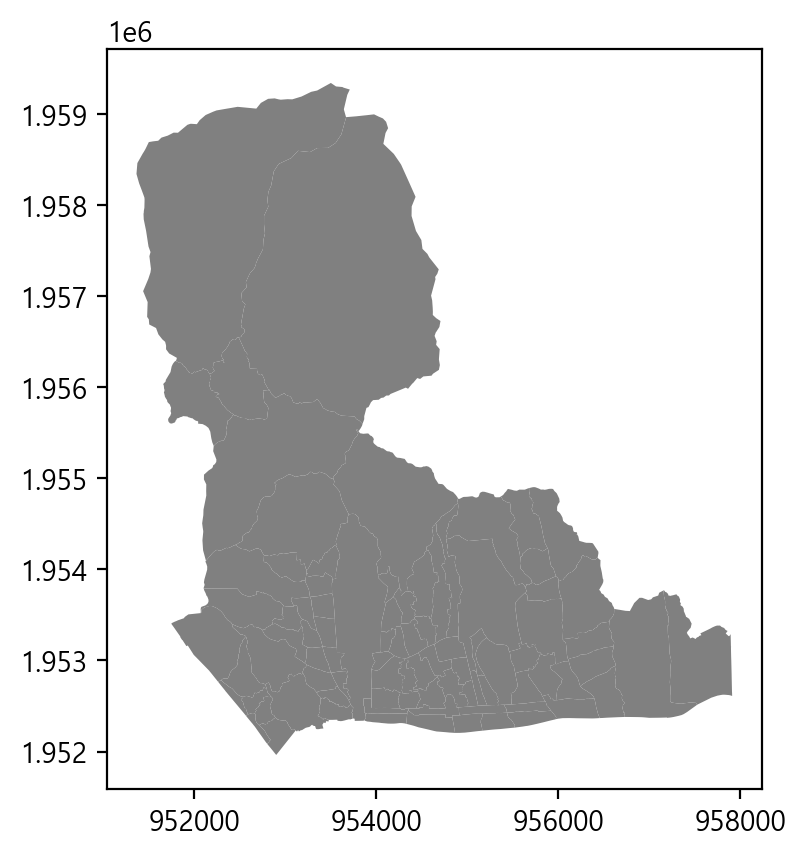

In [408]:
jongro_streets.plot(color = "grey")

<Axes: >

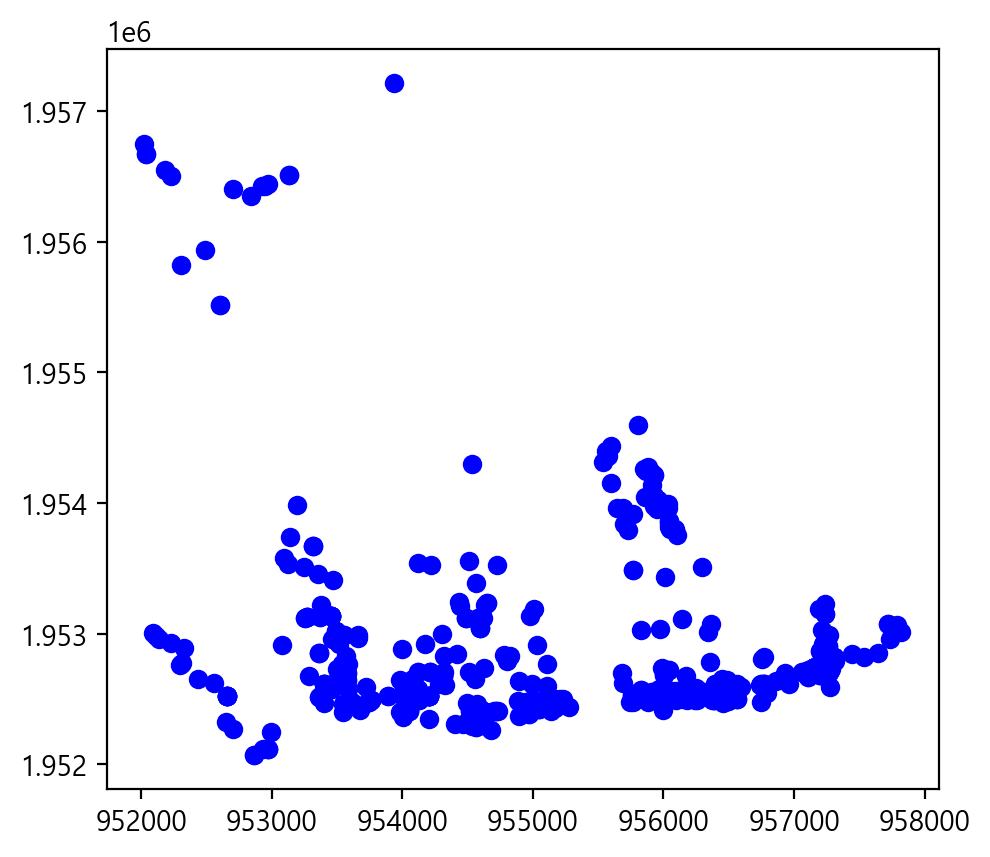

In [409]:
df_종로.plot(color = 'blue')

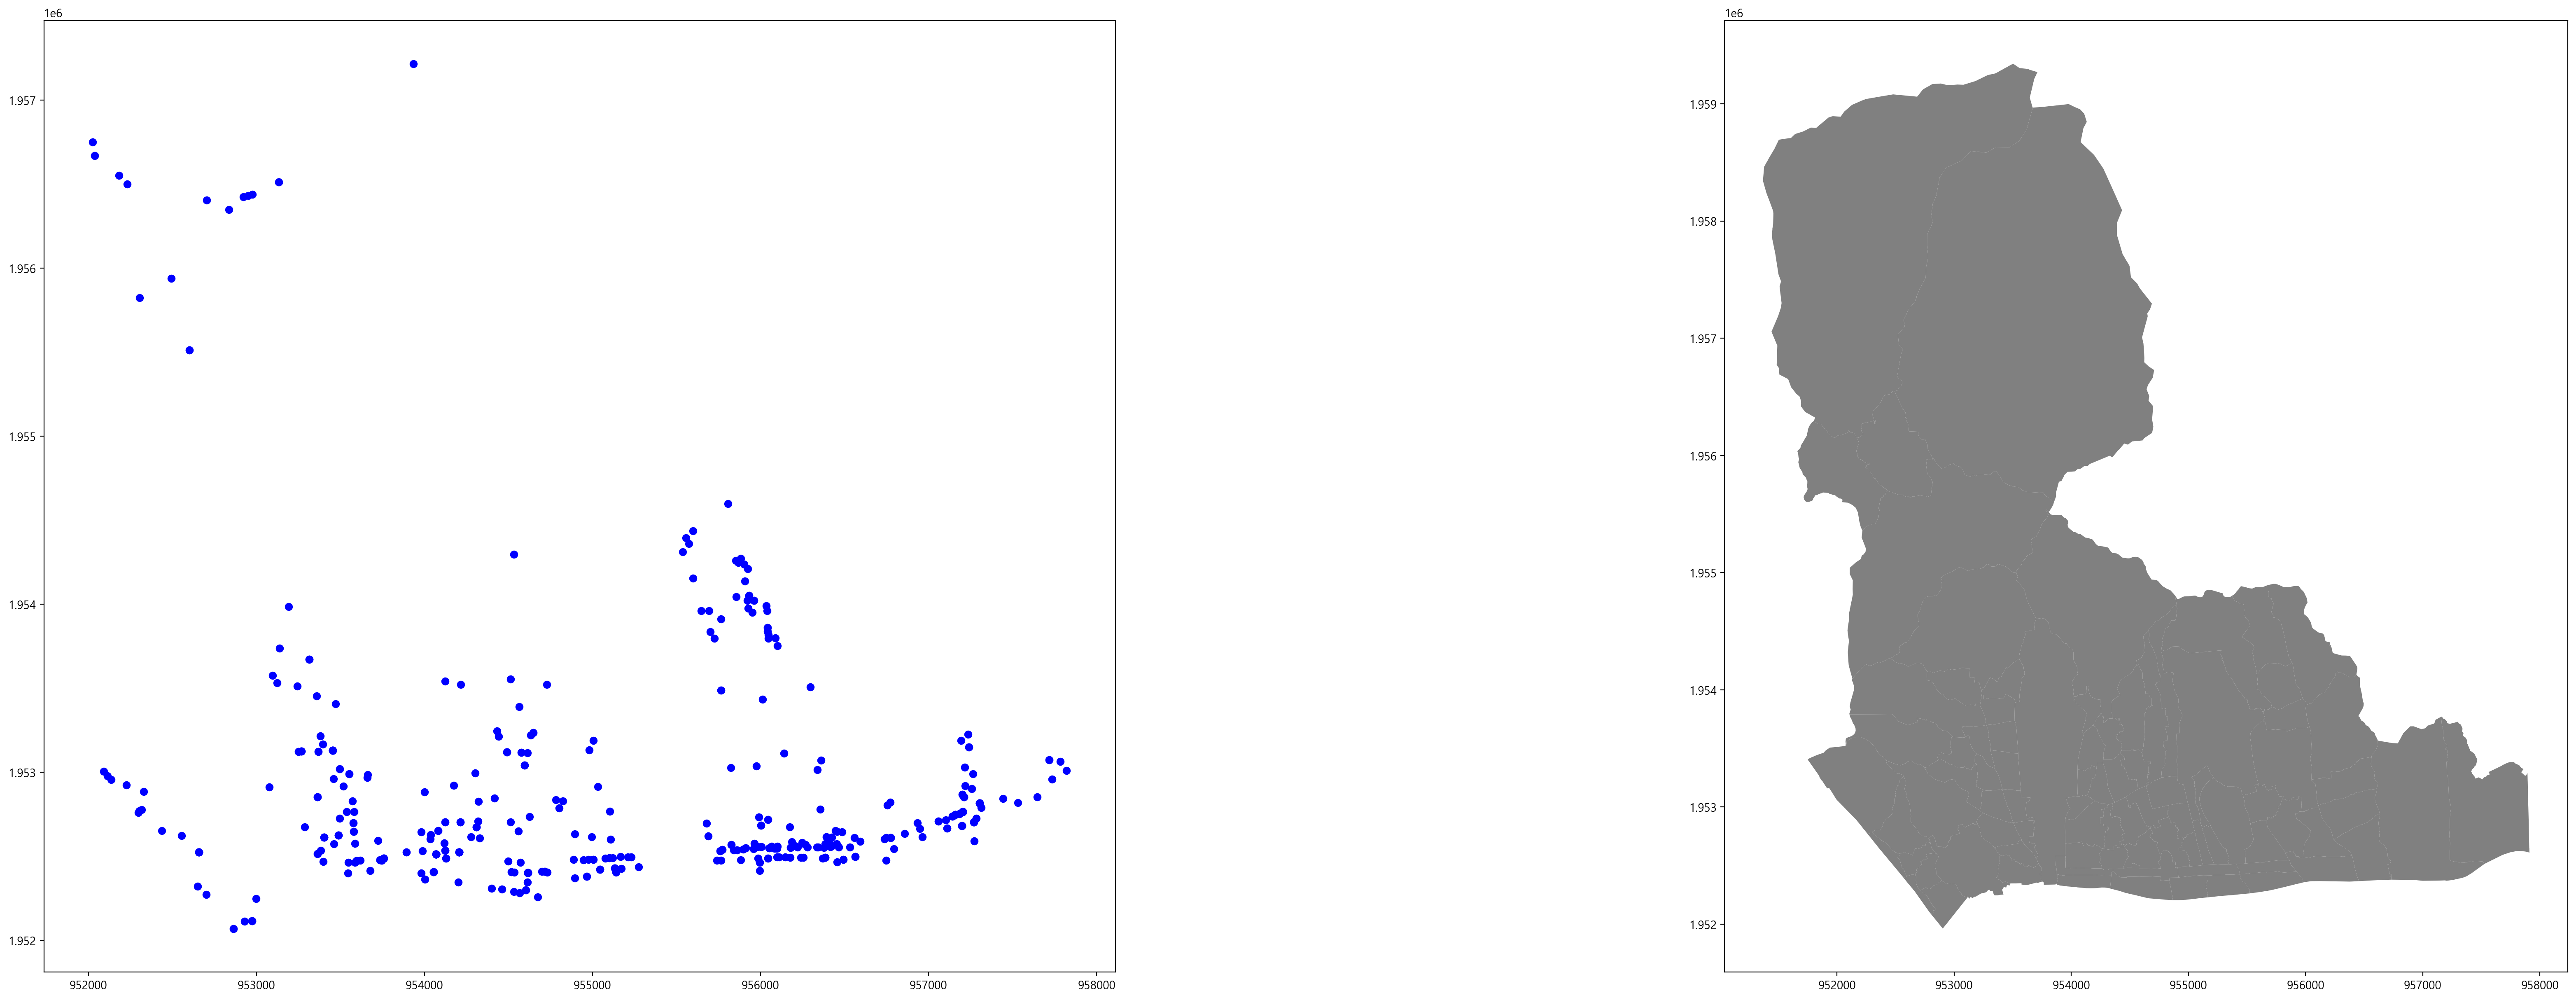

In [410]:
fig, ax =plt.subplots(1,2,figsize=(45,15))
df_종로.plot(color = 'blue', ax = ax[0])
jongro_streets.plot(color='grey', ax = ax[1])
plt.show()

<Axes: >

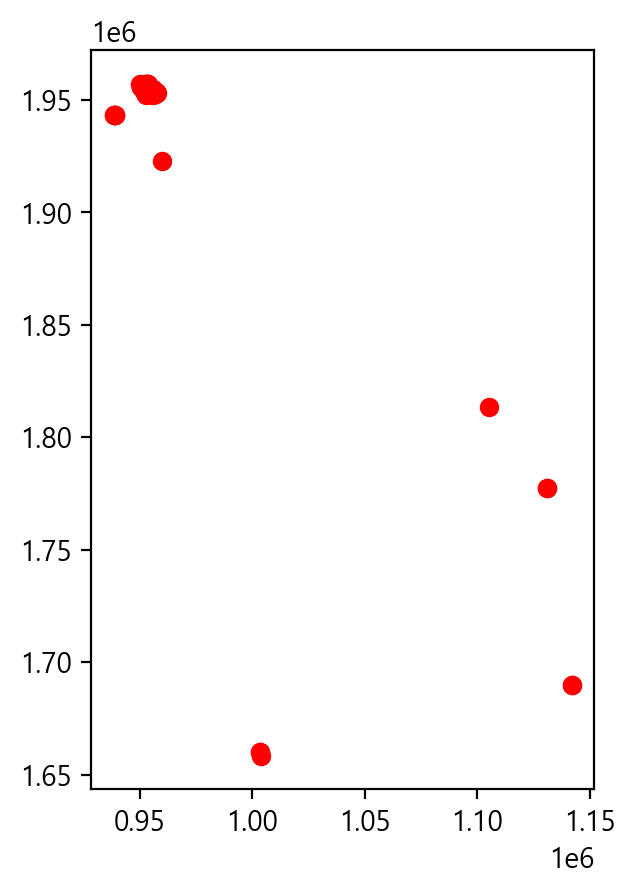

In [419]:
df_p_종로.plot(color = 'red')

In [411]:
# 고객수, 필요 설치개수 = x,y
client_count, facility_count = df_p_종로.shape[0], df_종로.shape[0]

# 설치개수
p_facilities = 3

# 커버할 수 있는 최대 지역 범위
max_coverage = 6500.0

# 커버할 수 있는 최소 지역 범위
min_coverage = 2000.0

title = "Jung Neighborhood X"

buff = 100
streets_buffer = get_buffer(jongro_streets, buff=buff)


streets = jongro_streets

clients = df_p_종로
clients["dv"] = ["x[%s]" % c for c in range(client_count)]



facilities = df_종로
facilities["dv"] = ["y[%s]" % c for c in range(facility_count)]

display(clients.head(2))
display(facilities.head(3))

2       장기요양기관                             주소   weights          도로명  \
0     보현데이케어센터    서울특별시 종로구 평창4길  21-22 (평창동)  1.350000   평창4길 21-22   
1  혜화동성당데이케어센터   서울특별시 종로구 혜화로12길  14-9 (혜화동)  1.047619  혜화로12길 14-9   

2          y           x         utmk_x        utmk_y  \
0  37.611627  126.963001  952605.144773  1.957046e+06   
1  37.590053  127.000125  955869.018953  1.954635e+06   

2                        geometry    dv  
0  POINT (952605.145 1957046.186)  x[0]  
1  POINT (955869.019 1954634.539)  x[1]

요양기관명  종별코드 시군구코드명           x          y         utmk_x        utmk_y  \
2     강북삼성병원     1    종로구  126.967750  37.568408  952997.160353  1.952249e+06   
16   서울대학교병원     1    종로구  126.999017  37.579715  955765.029626  1.953488e+06   
163  서울적십자병원    11    종로구  126.966997  37.567180  952929.925344  1.952113e+06   

                           geometry    dv  
2    POINT (952997.160 1952248.875)  y[0]  
16   POINT (955765.030 1953488.130)  y[1]  
163  POINT (952929.925 1952113.033)  y[2]

In [412]:
ntw = spaghetti.Network(in_data=streets)

ntw.snapobservations(clients, "clients", attribute=True)
clients_snapped = spaghetti.element_as_gdf(
    ntw, pp_name="clients", snapped=True
)
ntw.snapobservations(facilities, "facilities", attribute=True)
facilities_snapped = spaghetti.element_as_gdf(
    ntw, pp_name="facilities", snapped=True
)
cost_matrix = ntw.allneighbordistances(
    sourcepattern=ntw.pointpatterns["clients"],
    destpattern=ntw.pointpatterns["facilities"],
)
cost_matrix[:3,:3]

array([[6392.94817938, 6345.1516685 , 6706.14891533],
       [5621.77529693, 1223.28320258, 5723.84120778],
       [6392.94817938, 6345.1516685 , 6706.14891533]])

Solve Time: 0.0203000406 minutes
Obj. Value: 2.0 facilities needed for total coverage within a 4900.000000 meter service radius
--- 0 clients are not covered
--- 66 clients are covered by 1 facility
--- 8 clients are covered by 2 facilities


IndexError: list index out of range

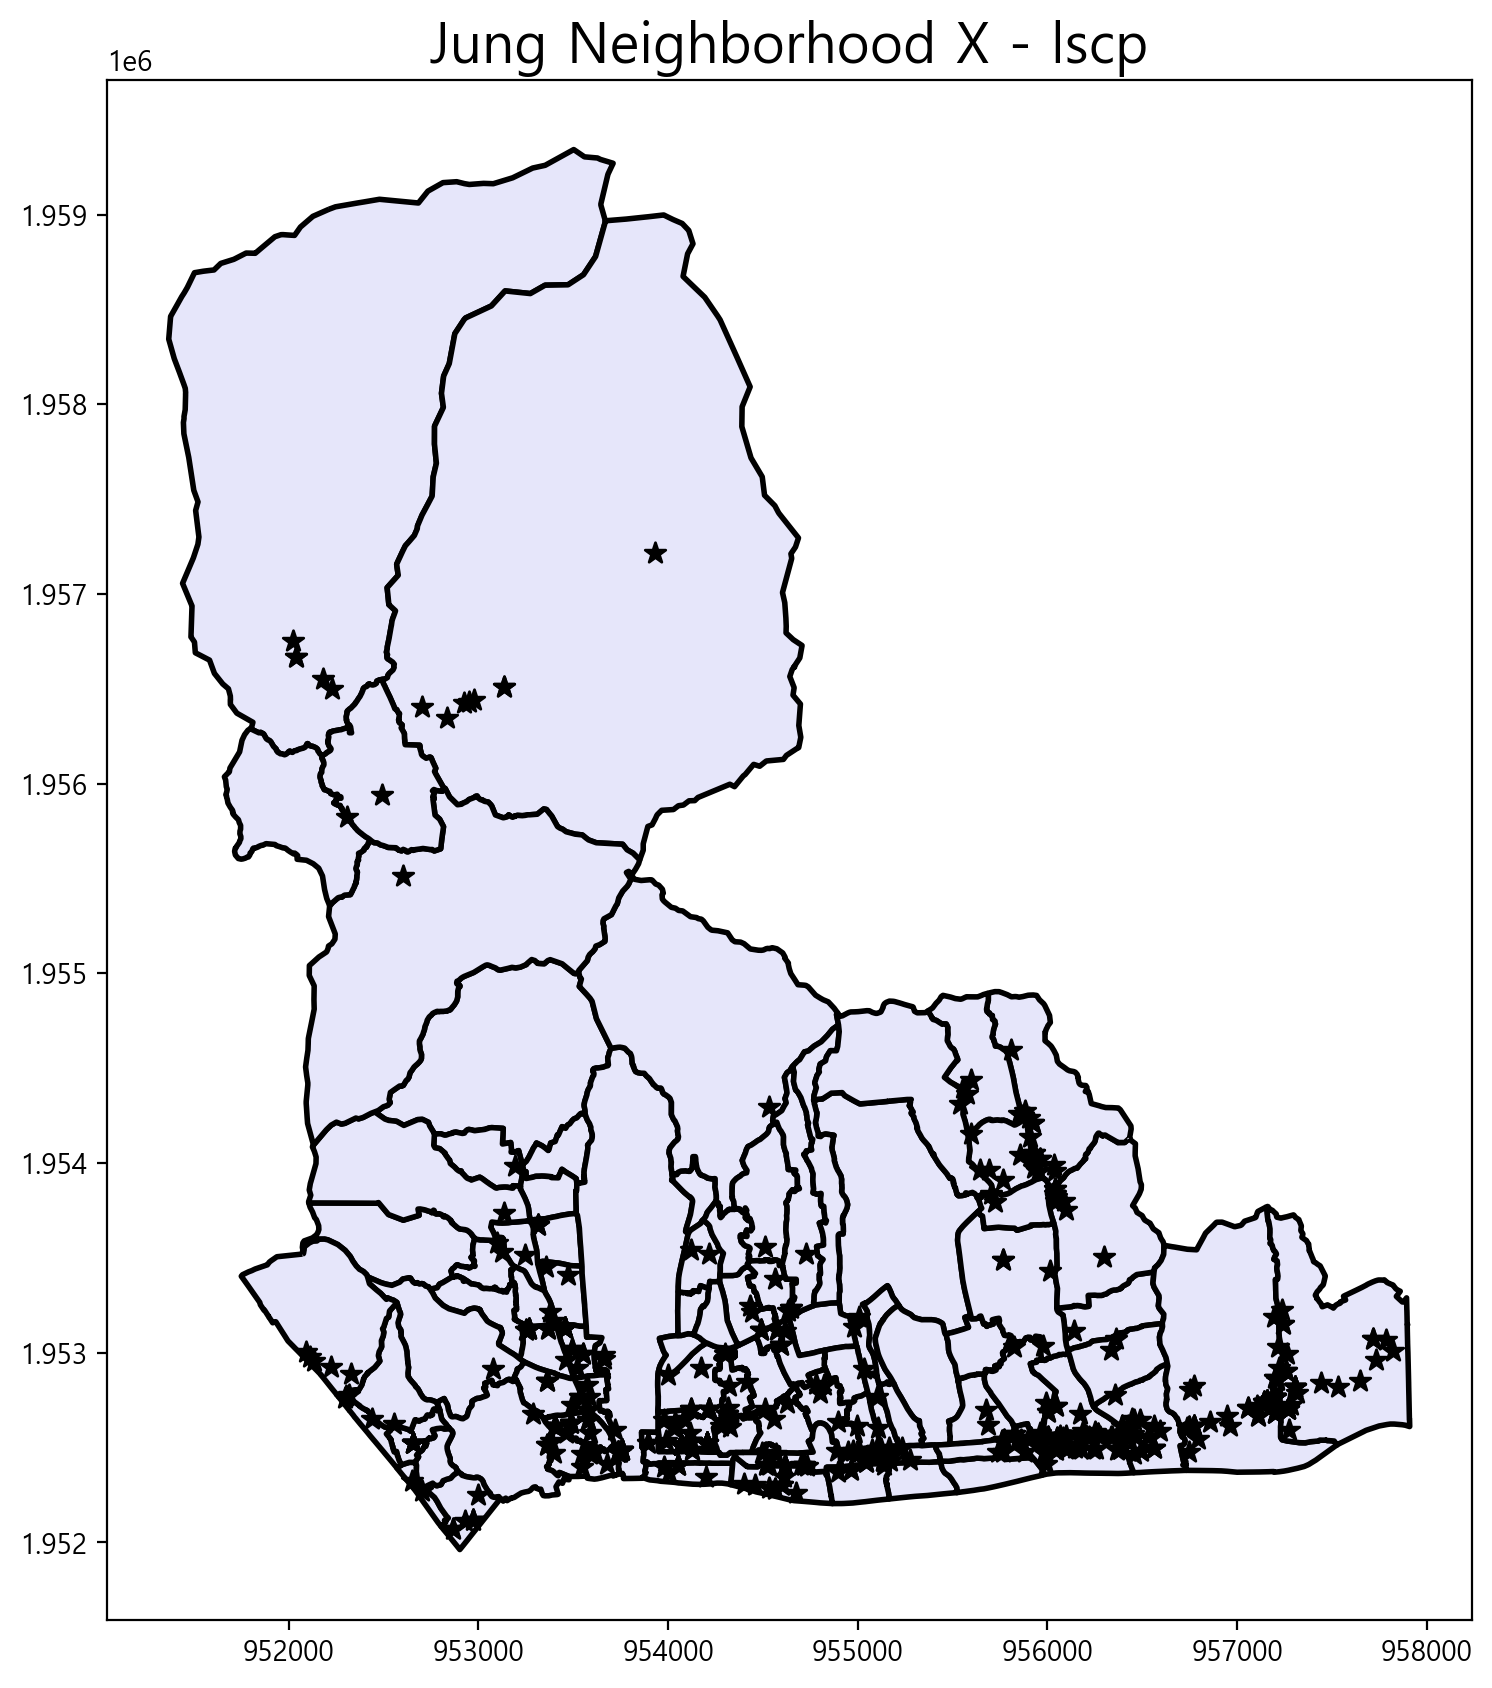

In [413]:
lscp = FacilityLocationModel("lscp", cij=cost_matrix, s=4900)
clients, facilities = add_results(lscp, clients, facilities)

aux_to_plot = {"streets": streets, "fac_tru": facilities}
res_to_plot = {"cli_var": clients, "fac_var": facilities}
plotter(
    plot_aux=aux_to_plot,
    plot_res=res_to_plot,
    pt1_size=300,
    pt2_size=60,
    model=lscp,
    title=title,
)


Solve Time: 0.017333368000000002 minutes
Obj. Value: 14.697310426532264 residents within 4000.000000 meters of 3 selected facilities
Percent of 14 clients covered: 100.000000
--- 52 clients are not covered
--- 14 clients are covered by 1 facility
--- 2 clients are covered by 2 facilities


IndexError: list index out of range

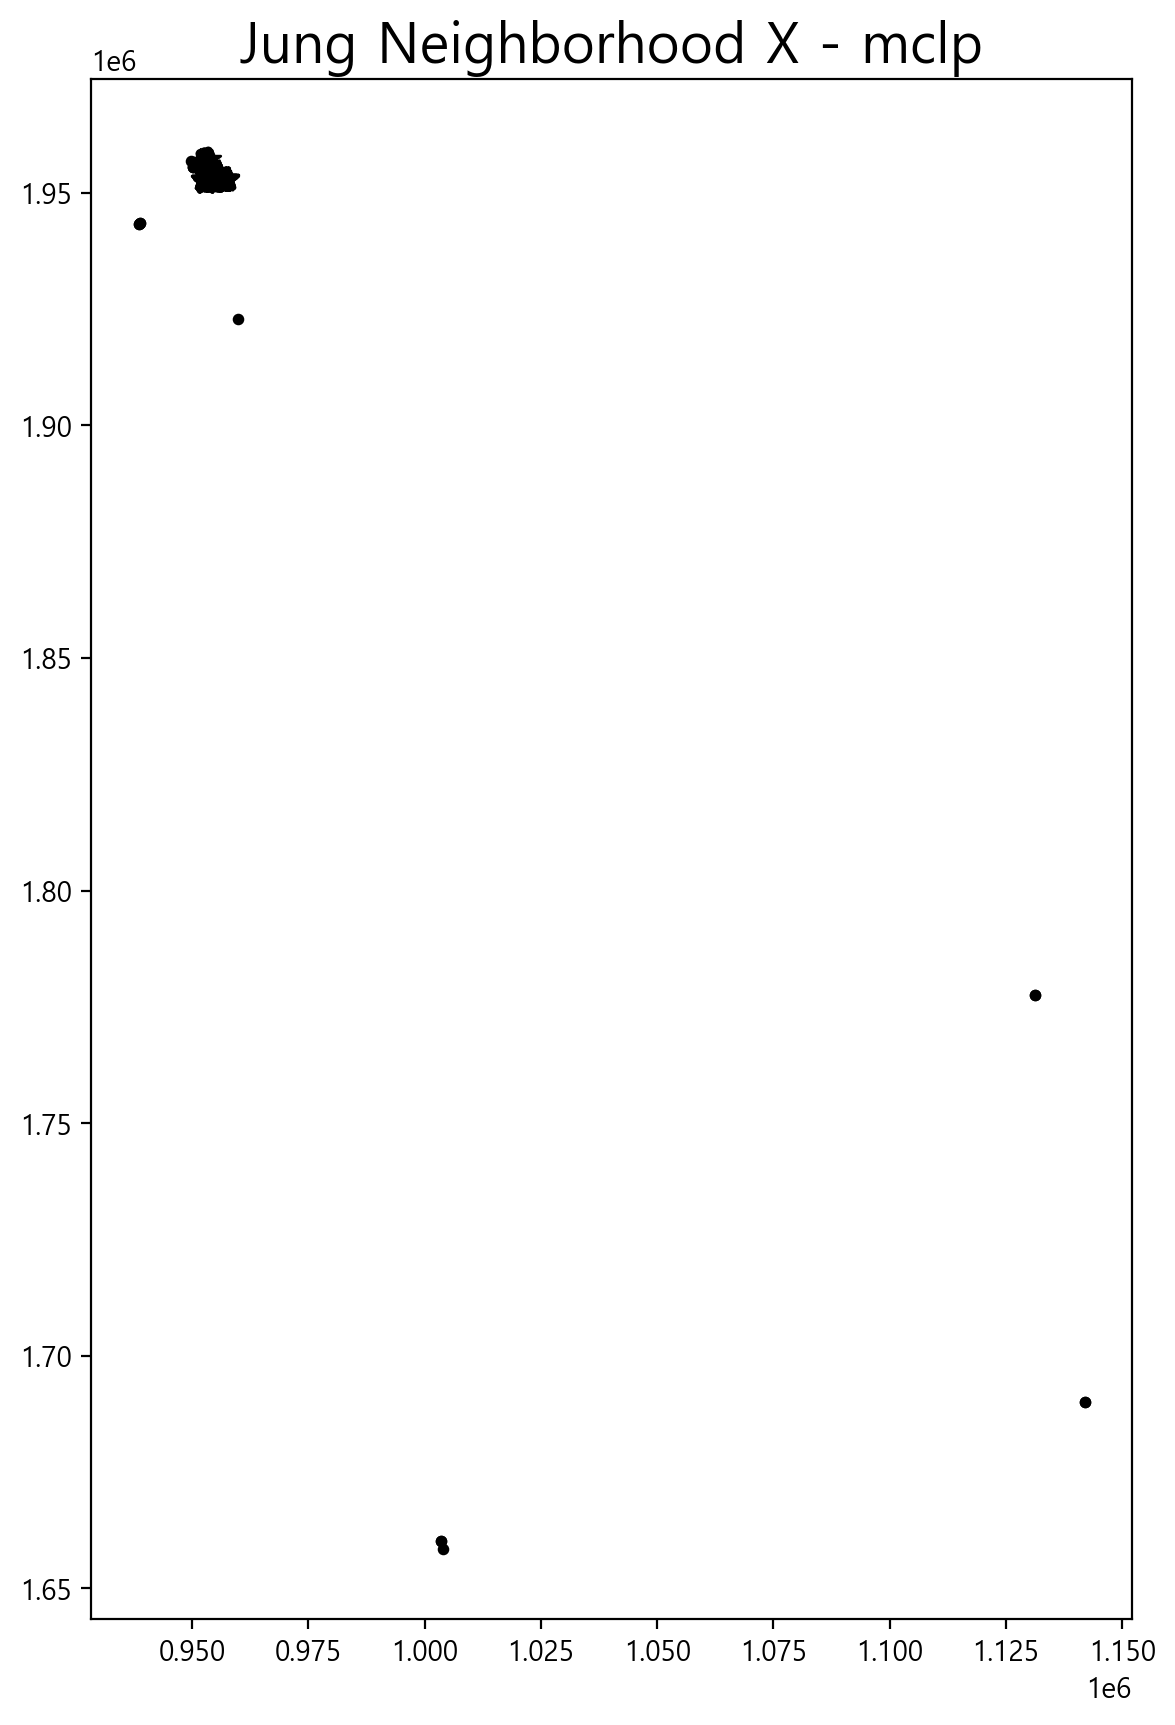

In [414]:
#### MCLP

mclp = FacilityLocationModel(
    "mclp", ai=clients["weights"], cij=cost_matrix, p=p_facilities, s=4000
)
clients, facilities = add_results(mclp, clients, facilities)

aux_to_plot = {"streets": streets, "cli_tru": clients, "fac_tru": facilities}
res_to_plot = {"cli_var": clients, "fac_var": facilities}
plotter(
    plot_aux=aux_to_plot,
    plot_res=res_to_plot,
    pt1_size=300,
    pt2_size=60,
    model=mclp,
    title=title,
)

In [416]:
models = [lscp, mclp]

analytics_df, analytics_display = analytics_matrix(models)
analytics_display

ValueError: `caption` must be either a string or 2-tuple of strings.

In [418]:

selection_df, selection_display = selection_matrix(models)
selection_display

In [420]:
facilities[facilities["mclp_sol"] != "closed"][["dv", "geometry"]]

dv                        geometry
10232   y[49]  POINT (957269.949 1952704.692)
27248  y[146]  POINT (953586.681 1952464.281)
45935  y[272]  POINT (952038.377 1956669.422)

<Axes: >

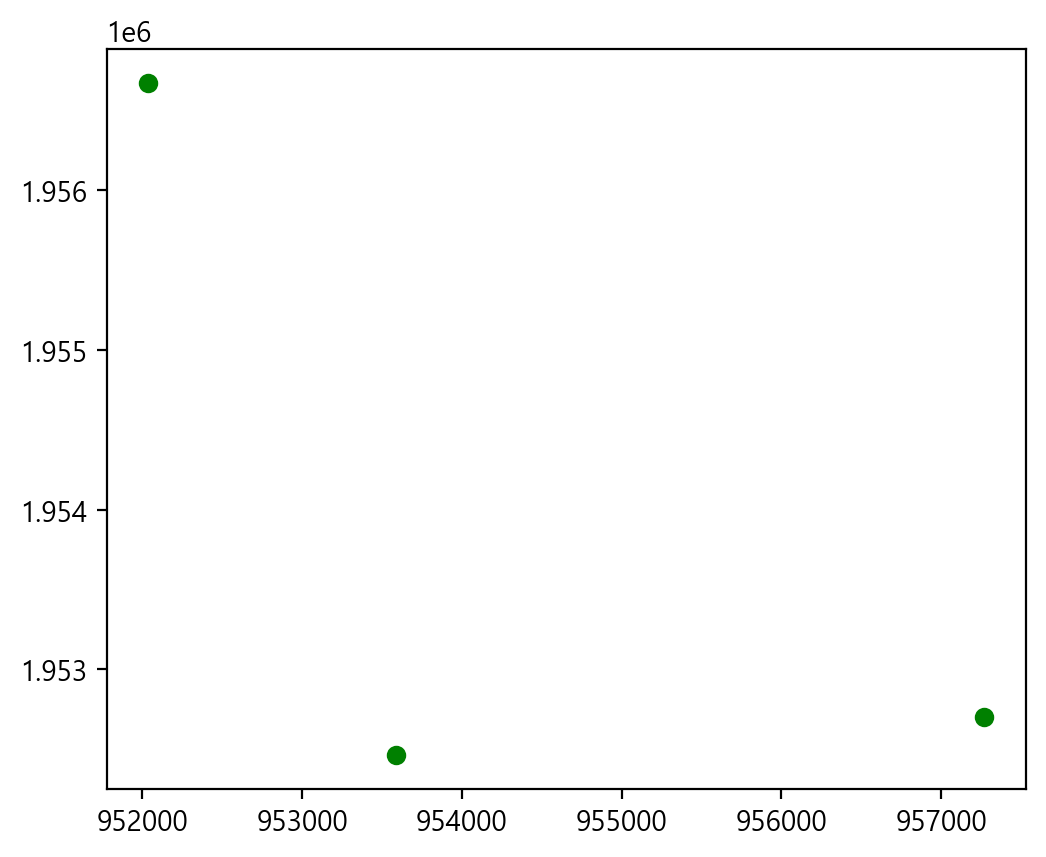

In [417]:
facilities[facilities["mclp_sol"] != "closed"][["dv", "geometry"]].plot(color='green')

In [421]:
import folium
print(f"folium Version: {folium.__version__}")

folium Version: 0.14.0


In [422]:
# 위도, 경도
lat, lon = 37.504811111562, 127.025492036104
# 줌 크기
zoom_size = 12

In [423]:
# 구글 지도 타일 설정
tiles = "http://mt0.google.com/vt/lyrs=s&hl=ko&x={x}&y={y}&z={z}"
# 속성 설정
attr = "Google"
# 지도 객체 생성
m = folium.Map(location = [lat, lon],
               zoom_start = zoom_size,
               tiles = tiles,
               attr = attr)
m

In [ ]:
#https://blog.naver.com/exabyte0320/221804585072  marker 표기하기 선정된 지역
#일단 좌표계 변환부터 하고